In [1]:
%matplotlib inline

from plotting import *
import pandas as pd, numpy as np, nibabel as nib, seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import glob, os, time, datetime
from IPython.core.display import Image, display
from sklearn import linear_model

sns.set_context('talk')
sns.set_style('white')

annotDir = '/scr/liberia1/data/Yeo_JNeurophysiol11_FreeSurfer'
docDir = '/afs/cbs.mpg.de/projects/mar005_lsd-lemon-surf/documents'
resDir = '/afs/cbs.mpg.de/projects/mar005_lsd-lemon-surf/results'
fsDir = "/afs/cbs.mpg.de/projects/mar004_lsd-lemon-preproc/freesurfer"

thrs = [70, 75, 80, 85 ,90, 95, 98]
yeo7_names = ['medial wall', 'visual', 'somatomotor', 'dorsal attention', 
              'ventral attention', 'limbic', 'frontoparietal', 'default']

yeo17_annot_f = '%s/fsaverage5/label/lh.Yeo2011_17Networks_N1000.annot' % (annotDir)
yeo17 = nib.freesurfer.io.read_annot(yeo17_annot_f)



def create_trmap(data, hemi):

    transition_map = np.zeros((10242))
    surf_f = '%s/fsaverage5/surf/%s.orig' % (fsDir, hemi)
    surf_faces = nib.freesurfer.io.read_geometry(surf_f)[1]
    subcort = np.sort(nib.freesurfer.io.read_label(
            '/afs/cbs.mpg.de/projects/mar004_lsd-lemon-preproc/freesurfer/fsaverage5/label/%s.Medial_wall.label' 
            % (hemi)))

    for node in range(10242):
        neighbors = np.unique(surf_faces[np.where(np.in1d(surf_faces.ravel(), [node]).
                                                  reshape(surf_faces.shape))[0]]).tolist()
        neighbors.remove(node)
        test = len(set(neighbors).intersection(set(subcort)))
        if test == 0:
            transition_map[node] = abs(max(np.subtract(data[neighbors], data[node])))
    
    return transition_map

/home/raid3/oligschlager/anaconda2/envs/distconnect/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
# lighter background plotting (doesnt work from plotting.py for some reason... )

'''
Functions for plotting surfaces with pure python code. 
Reduced version of nilearn surface plotting:
https://github.com/juhuntenburg/nilearn/tree/enh/surface_plotting

Helper function for symmetric colormap is copied from nilearn.
'''

def plot_surf_stat_map(coords, faces, stat_map=None,
                       elev=0, azim=0,
                       cmap='coolwarm',
                       threshold=None, bg_map=None,
                       bg_on_stat=False,
                       alpha='auto',
                       vmin=None, vmax=None,
                       cbar='sequential', # or'diverging'
                       symmetric_cbar="auto",
                       figsize=None,
                       labels=None, label_cpal=None,
                       mask=None, mask_lenient=None,
                       **kwargs):
    
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.tri as tri
    from mpl_toolkits.mplot3d import Axes3D
    import seaborn as sns
    
    # load mesh and derive axes limits
    faces = np.array(faces, dtype=int)
    limits = [coords.min(), coords.max()]

    # set alpha if in auto mode
    if alpha == 'auto':
        if bg_map is None:
            alpha = .5
        else:
            alpha = 1

    # if cmap is given as string, translate to matplotlib cmap
    if type(cmap) == str:
        cmap = plt.cm.get_cmap(cmap)

    # initiate figure and 3d axes
    if figsize is not None:
        fig = plt.figure(figsize=figsize)
    else:
        fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d', xlim=limits, ylim=limits)
    ax.view_init(elev=elev, azim=azim)
    ax.set_axis_off()

    # plot mesh without data
    p3dcollec = ax.plot_trisurf(coords[:, 0], coords[:, 1], coords[:, 2],
                                triangles=faces, linewidth=0.,
                                antialiased=False,
                                color='white')

    # where mask is indices of nodes to include:
    if mask is not None:    
        cmask = np.zeros(len(coords))
        cmask[mask] = 1
        cutoff = 2 # include triangles in cortex only if ALL nodes in mask
        if mask_lenient: # include triangles in cortex if ANY are in mask
            cutoff = 0
        fmask = np.where(cmask[faces].sum(axis=1) > cutoff)[0]    
    
    
    # If depth_map and/or stat_map are provided, map these onto the surface
    # set_facecolors function of Poly3DCollection is used as passing the
    # facecolors argument to plot_trisurf does not seem to work
    if bg_map is not None or stat_map is not None:

        face_colors = np.ones((faces.shape[0], 4))
        face_colors[:, :3] = .5*face_colors[:, :3]

        if bg_map is not None:
            bg_data = bg_map
            if bg_data.shape[0] != coords.shape[0]:
                raise ValueError('The bg_map does not have the same number '
                                 'of vertices as the mesh.')
            bg_faces = np.mean(bg_data[faces], axis=1)
            bg_faces = bg_faces - bg_faces.min()
            bg_faces = bg_faces / bg_faces.max()
            face_colors = plt.cm.gray_r(bg_faces)
            face_colors[:,0:3] = (-0.5)*face_colors[:,0:3]
            face_colors[:,0:3] = 1+face_colors[:,0:3]

        # modify alpha values of background
        face_colors[:, 3] = alpha*face_colors[:, 3]

        if stat_map is not None:
            stat_map_data = stat_map
            stat_map_faces = np.mean(stat_map_data[faces], axis=1)

            if cbar is 'diverging':
                print cbar
                # Call _get_plot_stat_map_params to derive symmetric vmin and vmax
                # And colorbar limits depending on symmetric_cbar settings
                cbar_vmin, cbar_vmax, vmin, vmax = \
                    _get_plot_stat_map_params(stat_map_faces, vmax,
                                              symmetric_cbar, kwargs)
            if cbar is 'sequential':
                if vmin is None:
                    vmin = stat_map_data.min()
                if vmax is None:
                    vmax = stat_map_data.max()

            if threshold is not None:
                kept_indices = np.where(abs(stat_map_faces) >= threshold)[0]
                stat_map_faces = stat_map_faces - vmin
                stat_map_faces = stat_map_faces / (vmax-vmin)
                if bg_on_stat:
                    face_colors[kept_indices] = cmap(stat_map_faces[kept_indices]) * face_colors[kept_indices]
                else:
                    face_colors[kept_indices] = cmap(stat_map_faces[kept_indices])
            else:
                stat_map_faces = stat_map_faces - vmin
                stat_map_faces = stat_map_faces / (vmax-vmin)
                if bg_on_stat:
                    if mask is not None:
                        face_colors[fmask] = cmap(stat_map_faces)[fmask] * face_colors[fmask]
                    else:
                        face_colors = cmap(stat_map_faces) * face_colors
                else:
                    if mask is not None:
                        face_colors[fmask] = cmap(stat_map_faces)[fmask] * face_colors[fmask]
                    else:
                        face_colors = cmap(stat_map_faces)

        if labels is not None:
            '''
            labels requires a tuple of label/s, each a list/array of node indices
            ----------------------------------------------------------------------
            color palette for labels
            if label_cpal is None, outlines will be black
            if it's a color palette name, a different color for each label will be generated
            if it's a list of rgb or color names, these will be used
            valid color names from http://xkcd.com/color/rgb/
            '''
            if label_cpal is not None:
                if type(label_cpal) == str:
                    cpal = sns.color_palette(label_cpal, len(labels))
                if type(label_cpal) == list:
                    if len(label_cpal) < len(labels):
                        raise ValueError('There are not enough colors in the color list.')
                    try:
                        cpal = sns.color_palette(label_cpal)
                    except:
                        cpal = sns.xkcd_palette(label_cpal)
        
            for n_label, label in enumerate(labels):
                for n_face, face in enumerate(faces):
                    count = len(set(face).intersection(set(label)))
                    if (count > 0) & (count < 3):
                        if label_cpal is None:
                            face_colors[n_face,0:3] = sns.xkcd_palette(["black"])[0]
                        else:
                            face_colors[n_face,0:3] = cpal[n_label]
                            
        p3dcollec.set_facecolors(face_colors)

    return fig


def _get_plot_stat_map_params(stat_map_data, vmax, symmetric_cbar, kwargs,
    force_min_stat_map_value=None):
    import numpy as np
    """ Internal function for setting value limits for plot_stat_map and
    plot_glass_brain.
    The limits for the colormap will always be set to range from -vmax to vmax.
    The limits for the colorbar depend on the symmetric_cbar argument, please
    refer to docstring of plot_stat_map.
    """
    # make sure that the color range is symmetrical
    if vmax is None or symmetric_cbar in ['auto', False]:
        # Avoid dealing with masked_array:
        if hasattr(stat_map_data, '_mask'):
            stat_map_data = np.asarray(
                    stat_map_data[np.logical_not(stat_map_data._mask)])
        stat_map_max = np.nanmax(stat_map_data)
        if force_min_stat_map_value == None:
            stat_map_min = np.nanmin(stat_map_data)
        else:
            stat_map_min = force_min_stat_map_value
    if symmetric_cbar == 'auto':
        symmetric_cbar = stat_map_min < 0 and stat_map_max > 0
    if vmax is None:
        vmax = max(-stat_map_min, stat_map_max)
    if 'vmin' in kwargs:
        raise ValueError('this function does not accept a "vmin" '
            'argument, as it uses a symmetrical range '
            'defined via the vmax argument. To threshold '
            'the map, use the "threshold" argument')
    vmin = -vmax
    if not symmetric_cbar:
        negative_range = stat_map_max <= 0
        positive_range = stat_map_min >= 0
        if positive_range:
            cbar_vmin = 0
            cbar_vmax = None
        elif negative_range:
            cbar_vmax = 0
            cbar_vmin = None
        else:
            cbar_vmin = stat_map_min
            cbar_vmax = stat_map_max
    else:
        cbar_vmin, cbar_vmax = None, None
    return cbar_vmin, cbar_vmax, vmin, vmax
    


    
    
    
    
    
def plot_surf_label(coords, faces, 
                    labels=None,
                    elev=0, azim=0,
                    cpal='bright',
                    threshold=None, 
                    bg_map=None,
                    bg_on_labels=False,
                    alpha='auto',
                    figsize=None,
                    **kwargs):
    
    '''
    - labels requires a tuple of label/s, each a list/array of node indices
    - cpal takes either the name of a seaborn color palette or matplotlib color map, 
      or a list of rgb values or color names from http://xkcd.com/color/rgb/
    '''
    
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.tri as tri
    from mpl_toolkits.mplot3d import Axes3D
    import seaborn as sns
    
    # load mesh and derive axes limits
    faces = np.array(faces, dtype=int)
    limits = [coords.min(), coords.max()]

    # set alpha if in auto mode
    if alpha == 'auto':
        if bg_map is None:
            alpha = .5
        else:
            alpha = 1

    # if cap is given as string, translate to seaborn color palette
    if type(cpal) == str:
        cpal = sns.color_palette(cpal, len(labels))
    if type(cpal) == list:
        if len(cpal) < len(labels):
            raise ValueError('There are not enough colors in the color list.')
        try:
            cpal = sns.color_palette(cpal)
        except:
            cpal = sns.xkcd_palette(cpal)
    
    # initiate figure and 3d axes
    if figsize is not None:
        fig = plt.figure(figsize=figsize)
    else:
        fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d', xlim=limits, ylim=limits)
    ax.view_init(elev=elev, azim=azim)
    ax.set_axis_off()

    # plot mesh without data
    p3dcollec = ax.plot_trisurf(coords[:, 0], coords[:, 1], coords[:, 2],
                                triangles=faces, linewidth=0.,
                                antialiased=False,
                                color='white')

    if bg_map is not None or labels is not None:

        face_colors = np.ones((faces.shape[0], 4))
        face_colors[:, :3] = .5*face_colors[:, :3]

        if bg_map is not None:
            bg_data = bg_map
            if bg_data.shape[0] != coords.shape[0]:
                raise ValueError('The bg_map does not have the same number '
                                 'of vertices as the mesh.')
            bg_faces = np.mean(bg_data[faces], axis=1)
            bg_faces = bg_faces - bg_faces.min()
            bg_faces = bg_faces / bg_faces.max()    
            face_colors = plt.cm.gray_r(bg_faces)
            face_colors[:,0:3] = (-0.5)*face_colors[:,0:3]
            face_colors[:,0:3] = 1+face_colors[:,0:3]
            
            
        # modify alpha values of background
        face_colors[:, 3] = alpha*face_colors[:, 3]

        # color the labels, either overriding or overlaying bg_map
        if labels is not None:
            for n_label,label in enumerate(labels):
                for n_face, face in enumerate(faces):
                    count = len(set(face).intersection(set(label)))
                    if count > 1:
                        if bg_on_labels:
                            face_colors[n_face,0:3] = cpal[n_label] * face_colors[n_face,0:3]
                        else:
                            face_colors[n_face,0:3] = cpal[n_label]
            
        p3dcollec.set_facecolors(face_colors)

    return fig

    
def crop_img(fig, margin=10):
    # takes fig, returns image
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    import os
    
    fig.savefig('./tempimage', bbox_inches='tight', orientation='landscape')
    plt.close(fig)
    img = mpimg.imread('./tempimage.png')
    os.remove('./tempimage.png')    
    
    kept = {'rows':[], 'cols':[]}
    for row in range(img.shape[0]):
        if len(set(np.ndarray.flatten(img[row,:,:]))) > 1:
            kept['rows'].append(row)
    for col in range(img.shape[1]):
        if len(set(np.ndarray.flatten(img[:,col,:]))) > 1:
            kept['cols'].append(col)
    
    if margin:
        return img[min(kept['rows'])-margin:max(kept['rows'])+margin,
                   min(kept['cols'])-margin:max(kept['cols'])+margin]
    else:
        return img[kept['rows']][:,kept['cols']]
        
        


def create_fig(data=None, labels=None, 
               hemi=None, surf='pial',
               sulc=True, alpha='auto',
               cmap='cubehelix', cpal='bright', cbar=False,
               dmin=None, dmax=None,
               mask=None):
    
    import nibabel as nib, numpy as np
    import matplotlib.pyplot as plt, matplotlib as mpl
    from IPython.core.display import Image, display
    import os     
    
    fsDir = '/afs/cbs.mpg.de/projects/mar004_lsd-lemon-preproc/freesurfer'
    surf_f = '%s/fsaverage5/surf/%s.%s' % (fsDir, hemi, surf)
    coords = nib.freesurfer.io.read_geometry(surf_f)[0]
    faces = nib.freesurfer.io.read_geometry(surf_f)[1]
    if sulc:
        sulc_f = '%s/fsaverage5/surf/%s.sulc' % (fsDir, hemi)
        sulc = nib.freesurfer.io.read_morph_data(sulc_f)
        sulc_bool = True
    else:
        sulc = None
        sulc_bool = False
      
    # create images
    imgs = []        
    for azim in [0, 180]:
        
        if data is not None:
            if dmin is None:
                dmin = data[np.nonzero(data)].min()
            if dmax is None:
                dmax = data.max()
            fig = plot_surf_stat_map(coords, faces, stat_map=data,
                                 elev=0, azim=azim,
                                 cmap=cmap,
                                 bg_map=sulc,bg_on_stat=sulc_bool,
                                 vmin=dmin, vmax=dmax,
                                 labels=labels,
                                 alpha=alpha,
                                 mask=mask, mask_lenient=False)
                                 #label_cpal=cpal)
        else:
            fig = plot_surf_label(coords, faces, 
                                  labels=labels,
                                  elev=0, azim=azim,                             
                                  bg_map=sulc,
                                  cpal=cpal,
                                  bg_on_labels=sulc_bool,
                                  alpha=alpha)

        # crop image
        imgs.append((crop_img(fig, margin=15)),)
        plt.close(fig)

    # create figure with color bar
    fig = plt.figure()
    fig.set_size_inches(8, 4)

    ax1 = plt.subplot2grid((4,60), (0,0),  colspan = 26, rowspan =4)
    plt.imshow(imgs[0])
    ax1.set_axis_off()

    ax2 = plt.subplot2grid((4,60), (0,28),  colspan = 26, rowspan =4)
    plt.imshow(imgs[1])
    ax2.set_axis_off()
    
    if cbar==True and data is not None:  
        cax = plt.subplot2grid((4,60), (1,59),  colspan = 1, rowspan =2)
        cmap = plt.cm.get_cmap(cmap)
        norm = mpl.colors.Normalize(vmin=dmin, vmax=dmax)
        cb = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm)
        cb.set_ticks([dmin, dmax])
    
    fig.savefig('./tempimage')
    plt.close(fig)
    display(Image(filename='./tempimage.png', width=800))
    os.remove('./tempimage.png')      
    
    
    
def create_fig_both(data=None, labels=None, 
               order=['lh', 'rh'], surf='pial',
               sulc=True, alpha='auto',
               cmap='cubehelix', cpal='bright', cbar=False,
               cbar_label=None,
               dmin=None, dmax=None,
               mask=None):
    
    import nibabel as nib, numpy as np
    import matplotlib.pyplot as plt, matplotlib as mpl
    from IPython.core.display import Image, display
    import os     
    
    imgs = [] 
    for n, hemi in enumerate(order): 
    
        fsDir = '/afs/cbs.mpg.de/projects/mar004_lsd-lemon-preproc/freesurfer'
        surf_f = '%s/fsaverage5/surf/%s.%s' % (fsDir, hemi, surf)
        coords = nib.freesurfer.io.read_geometry(surf_f)[0]
        faces = nib.freesurfer.io.read_geometry(surf_f)[1]
        
        if sulc is not None:
            sulc_f = '%s/fsaverage5/surf/%s.sulc' % (fsDir, hemi)
            sulc = nib.freesurfer.io.read_morph_data(sulc_f)
            sulc_bool = True
        else:
            sulc = None
            sulc_bool = False

        # create images      
        for azim in [0, 180]:

            if data[n] is not None:
                if dmin is None:
                    dmin = data[np.nonzero(data)].min()
                if dmax is None:
                    dmax = data.max()
                fig = plot_surf_stat_map(coords, faces, stat_map=data[n],
                                     elev=0, azim=azim,
                                     cmap=cmap,
                                     bg_map=sulc,bg_on_stat=sulc_bool,
                                     vmin=dmin, vmax=dmax,
                                     labels=labels,
                                     alpha=alpha,
                                     mask=mask[n], mask_lenient=False)
                                     #label_cpal=cpal)
            else:
                fig = plot_surf_label(coords, faces, 
                                      labels=labels,
                                      elev=0, azim=azim,                             
                                      bg_map=sulc,
                                      cpal=cpal,
                                      bg_on_labels=sulc_bool,
                                      alpha=alpha)

            # crop image
            imgs.append((crop_img(fig, margin=15)),)
            plt.close(fig)

    # create figure with color bar
    fig = plt.figure()
    fig.set_size_inches(8, 4)

    ax1 = plt.subplot2grid((8,60), (0,0),  colspan = 26, rowspan =4)
    plt.imshow(imgs[1])
    ax1.set_axis_off()

    ax2 = plt.subplot2grid((8,60), (0,28),  colspan = 26, rowspan =4)
    plt.imshow(imgs[2])
    ax2.set_axis_off()
    
    ax3 = plt.subplot2grid((8,60), (4,0),  colspan = 26, rowspan =4)
    plt.imshow(imgs[0])
    ax3.set_axis_off()

    ax4 = plt.subplot2grid((8,60), (4,28),  colspan = 26, rowspan =4)
    plt.imshow(imgs[3])
    ax4.set_axis_off()
    
    
    if cbar==True and data is not None:  
        cax = plt.subplot2grid((8,60), (2,58),  colspan = 1, rowspan =4)
        cmap = plt.cm.get_cmap(cmap)
        norm = mpl.colors.Normalize(vmin=dmin, vmax=dmax)
        cb = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm)
        cb.set_ticks([dmin, dmax])
        cb.set_label(cbar_label)
    
    fig.savefig('./tempimage')
    plt.close(fig)
    display(Image(filename='./tempimage.png', width=800))
    os.remove('./tempimage.png')           

In [3]:
def create_fig_both(data=None, labels=None, 
               order=['lh', 'rh'], surf='pial',
               sulc=True, alpha='auto',
               cmap='cubehelix', cpal='bright', cbar=False,
               cbar_label=None,
               dmin=None, dmax=None,
               mask=None):
    
    import nibabel as nib, numpy as np
    import matplotlib.pyplot as plt, matplotlib as mpl
    from IPython.core.display import Image, display
    import os     
    
    imgs = [] 
    for n, hemi in enumerate(order): 
    
        fsDir = '/afs/cbs.mpg.de/projects/mar004_lsd-lemon-preproc/freesurfer'
        surf_f = '%s/fsaverage5/surf/%s.%s' % (fsDir, hemi, surf)
        coords = nib.freesurfer.io.read_geometry(surf_f)[0]
        faces = nib.freesurfer.io.read_geometry(surf_f)[1]
        
        if sulc is not None:
            sulc_f = '%s/fsaverage5/surf/%s.sulc' % (fsDir, hemi)
            sulc = nib.freesurfer.io.read_morph_data(sulc_f)
            sulc_bool = True
        else:
            sulc = None
            sulc_bool = False

        # create images      
        for azim in [0, 180]:

            if data[n] is not None:
                if dmin is None:
                    dmin = data[np.nonzero(data)].min()
                if dmax is None:
                    dmax = data.max()
                fig = plot_surf_stat_map(coords, faces, stat_map=data[n],
                                     elev=0, azim=azim,
                                     cmap=cmap,
                                     bg_map=sulc,bg_on_stat=sulc_bool,
                                     vmin=dmin, vmax=dmax,
                                     labels=labels,
                                     alpha=alpha,
                                     mask=mask[n], mask_lenient=False)
                                     #label_cpal=cpal)
            else:
                fig = plot_surf_label(coords, faces, 
                                      labels=labels,
                                      elev=0, azim=azim,                             
                                      bg_map=sulc,
                                      cpal=cpal,
                                      bg_on_labels=sulc_bool,
                                      alpha=alpha)

            # crop image
            imgs.append((crop_img(fig, margin=15)),)
            plt.close(fig)

    # create figure with color bar
    fig = plt.figure()
    fig.set_size_inches(6, 4)

    ax1 = plt.subplot2grid((32,4), (0,0),  colspan = 2, rowspan =14)
    plt.imshow(imgs[1])
    ax1.set_axis_off()

    ax2 = plt.subplot2grid((32,4), (0,2),  colspan = 2, rowspan =14)
    plt.imshow(imgs[2])
    ax2.set_axis_off()
    
    ax3 = plt.subplot2grid((32,4), (14,0),  colspan = 2, rowspan =14)
    plt.imshow(imgs[0])
    ax3.set_axis_off()

    ax4 = plt.subplot2grid((32,4), (14,2),  colspan = 2, rowspan =14)
    plt.imshow(imgs[3])
    ax4.set_axis_off()
    
    
    if cbar==True and data is not None:  
        cax = plt.subplot2grid((32,4), (30,1),  colspan = 2, rowspan =1)
        cmap = plt.cm.get_cmap(cmap)
        norm = mpl.colors.Normalize(vmin=dmin, vmax=dmax)
        cb = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation='horizontal')
        cb.set_ticks([dmin, dmax])
        cb.set_label(cbar_label)
    
    fig.savefig('./tempimage')
    plt.close(fig)
    display(Image(filename='./tempimage.png', width=800))
    os.remove('./tempimage.png')           

In [4]:
def create_fig_both(data=None, labels=None, label_col=None,
               order=['lh', 'rh'], surf='pial',
               sulc=True, alpha='auto',
               cmap='cubehelix', cpal='bright', 
               cbar=False, cbar_label=None,
               dmin=None, dmax=None,
               mask=None):
    
    import nibabel as nib, numpy as np
    import matplotlib.pyplot as plt, matplotlib as mpl
    from IPython.core.display import Image, display
    import os     
    
    imgs = [] 
    for n, hemi in enumerate(order): 
    
        fsDir = '/afs/cbs.mpg.de/projects/mar004_lsd-lemon-preproc/freesurfer'
        surf_f = '%s/fsaverage5/surf/%s.%s' % (fsDir, hemi, surf)
        coords = nib.freesurfer.io.read_geometry(surf_f)[0]
        faces = nib.freesurfer.io.read_geometry(surf_f)[1]
        
        if sulc is not None:
            sulc_f = '%s/fsaverage5/surf/%s.sulc' % (fsDir, hemi)
            sulc = nib.freesurfer.io.read_morph_data(sulc_f)
            sulc_bool = True
        else:
            sulc = None
            sulc_bool = False

        # create images      
        for azim in [0, 180]:

            if data[n] is not None:
                if dmin is None:
                    dmin = data[np.nonzero(data)].min()
                if dmax is None:
                    dmax = data.max()
                fig = plot_surf_stat_map(coords, faces, stat_map=data[n],
                                     elev=0, azim=azim,
                                     cmap=cmap,
                                     bg_map=sulc,bg_on_stat=sulc_bool,
                                     vmin=dmin, vmax=dmax,
                                     labels=labels[n], label_col=label_col,
                                     alpha=alpha,
                                     mask=mask[n], mask_lenient=False,
                                     label_cpal=cpal)
            else:
                fig = plot_surf_label(coords, faces, 
                                      labels=labels[n],
                                      elev=0, azim=azim,                             
                                      bg_map=sulc,
                                      cpal=cpal[n],
                                      bg_on_labels=sulc_bool,
                                      alpha=alpha)

            # crop image
            imgs.append((crop_img(fig, margin=15)),)
            plt.close(fig)

    # create figure with color bar
    fig = plt.figure()
    fig.set_size_inches(6, 4)

    ax1 = plt.subplot2grid((32,4), (0,0),  colspan = 2, rowspan =14)
    plt.imshow(imgs[1])
    ax1.set_axis_off()

    ax2 = plt.subplot2grid((32,4), (0,2),  colspan = 2, rowspan =14)
    plt.imshow(imgs[2])
    ax2.set_axis_off()
    
    ax3 = plt.subplot2grid((32,4), (14,0),  colspan = 2, rowspan =14)
    plt.imshow(imgs[0])
    ax3.set_axis_off()

    ax4 = plt.subplot2grid((32,4), (14,2),  colspan = 2, rowspan =14)
    plt.imshow(imgs[3])
    ax4.set_axis_off()
    
    
    if cbar==True and data is not None:  
        cax = plt.subplot2grid((32,4), (30,1),  colspan = 2, rowspan =1)
        cmap = plt.cm.get_cmap(cmap)
        norm = mpl.colors.Normalize(vmin=dmin, vmax=dmax)
        cb = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation='horizontal')
        cb.set_ticks([dmin, dmax])
        cb.set_label(cbar_label)
    
    fig.savefig('./tempimage')
    plt.close(fig)
    display(Image(filename='./tempimage.png', width=800))
    os.remove('./tempimage.png')             


### read in data

In [5]:
# group average meanDist
df = pd.read_pickle(max(glob.iglob('%s/data_grouplevel/lsd_data_grouplevel_20*.pkl' % docDir), 
                        key=os.path.getctime))
df = df[df['sample'] == 'LSD subjects']
df = df[df['threshold'] == '95']


# distance
gr_dist_lh = np.load('%s/data_grouplevel/lsd_geoDist_groupmean_lh.npy' % docDir)
renorm_lh = gr_dist_lh.max()

gr_dist_rh = np.load('%s/data_grouplevel/lsd_geoDist_groupmean_rh.npy' % docDir)
renorm_rh = gr_dist_rh.max()

# meanDist in mm
df_mm = df.copy()
#renorm = (renorm_lh+renorm_rh)/2
df_mm['mean distance (geodesic) - group mean'][df_mm['hemisphere']=='lh'] = df_mm['mean distance (geodesic) - group mean'][df_mm['hemisphere']=='lh'] * renorm_lh
df_mm['mean distance (geodesic) - group mean'][df_mm['hemisphere']=='rh'] = df_mm['mean distance (geodesic) - group mean'][df_mm['hemisphere']=='rh'] * renorm_rh


/home/raid3/oligschlager/anaconda2/envs/distconnect/lib/python2.7/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/raid3/oligschlager/anaconda2/envs/distconnect/lib/python2.7/site-packages/ipykernel/__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### mean distance components and transitions

In [4]:
#n_comp = 3
#comp_annot_rh = np.load('%s/clustering/clust_%icomp_rh.npy' % (resDir,n_comp))
#comp_annot_lh = np.load('%s/clustering/clust_%icomp_lh.npy' % (resDir,n_comp))


In [5]:
#n_comp = 3
#comp_labels_rh = np.load('%s/clustering/clust_%icomp_rh.npy' % (resDir,n_comp))
#comp_labels_lh = np.load('%s/clustering/clust_%icomp_lh.npy' % (resDir,n_comp))



lh
used cortical areas to define primary regions


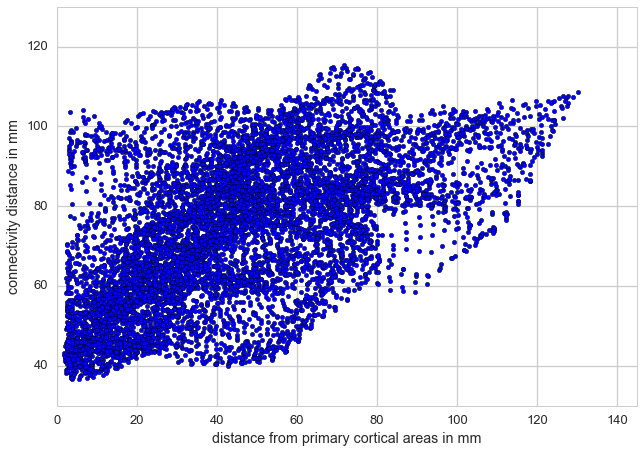



rh
used cortical areas to define primary regions


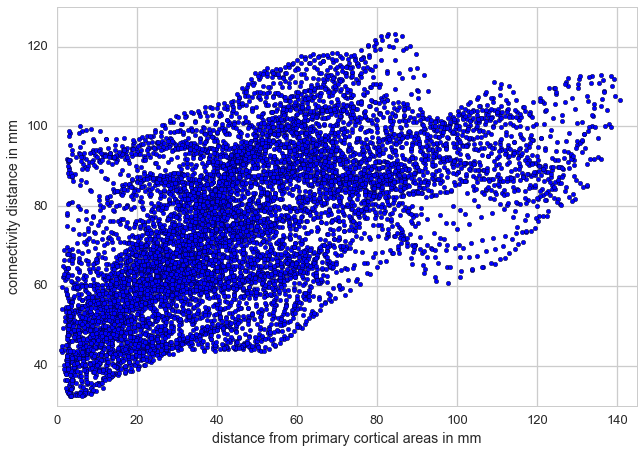

In [7]:
dist_to_primary_comp_both = []
meanDist_comp_both =[]

dist_to_primary_areas_both = []
dist_to_primary_areas_both_surf = []
dist_to_primary_areas_both_labels = []
meanDist_areas_both =[]


for hemi in ['lh', 'rh']:
    print '\n\n%s' % hemi
    
    # component labels ('annot format') and group distance
    if hemi == 'lh':
        #comp_labels = [np.where(comp_labels_lh == comp)[0] for comp in range(1,n_comp+1)]
        gr_dist = gr_dist_lh
    if hemi == 'rh':
        #comp_labels = [np.where(comp_labels_rh == comp)[0] for comp in range(1,n_comp+1)]
        gr_dist = gr_dist_rh
    
    
    # mean distance map
    meanDist = df_mm[['mean distance (geodesic) - group mean']][df_mm['hemisphere'] == hemi].as_matrix().squeeze()
     
    # distance to primary component
    #comp_order = np.argsort([meanDist[comp_labels[comp]].mean() for comp in range(n_comp)])  
    #primary_comp_labels = comp_labels[comp_order[0]]
    #rest_comp_labels = np.sort(np.concatenate((comp_labels[comp_order[1]],comp_labels[comp_order[2]])))
    #dist_to_primary_comp = np.array([min(gr_dist[node][primary_comp_labels]) for node in range((10242))])
    
    # distance to primary areas
    primary_area_labels = []
    primary_cortices = ['G_postcentral','G_precentral','S_calcarine','S_central','S_temporal_transverse']
    for area in primary_cortices:
        temp = map(int, list(set(df['node'][(df['region in Destrieux Atlas']==area)&(df['hemisphere']==hemi)])))
        primary_area_labels.extend(np.sort(np.array(temp)))
    primary_area_labels = np.sort(list(set(primary_area_labels)))
    dist_to_primary_areas = np.array([min(gr_dist[node][primary_area_labels]) for node in range((10242))])
    cort = np.sort(nib.freesurfer.io.read_label('%s/fsaverage5/label/%s.cortex.label' % (fsDir, hemi)))
    rest_area_labels = np.array(list(set(cort).difference(set(primary_area_labels))))
    
    
    # transition map of mean distance
    trmap = create_trmap(meanDist, hemi)
    
    # combine distance maps from hemis
    #dist_to_primary_comp_both.extend(list(dist_to_primary_comp[rest_comp_labels]))
    #meanDist_comp_both.extend(list(meanDist[rest_comp_labels]))
    
    dist_to_primary_areas_both.extend(list(dist_to_primary_areas[rest_area_labels]))
    meanDist_areas_both.extend(list(meanDist[rest_area_labels]))
    dist_to_primary_areas_both_surf.append(dist_to_primary_areas)
    dist_to_primary_areas_both_labels.append(primary_area_labels)
    
    
    
    
    # plots
    sns.set_style('white')
    
    #create_fig(labels=comp_labels, hemi=hemi, surf='inflated', cbar=True, cpal='cubehelix')
    #create_fig(data=trmap, labels=comp_labels, label_col='green', hemi=hemi, surf='inflated', 
    #cmap='spectral', dmin=0, dmax=7.5, sulc=False,cbar=True) #dmax=np.percentile(trmap, 95)
    
    print 'used cortical areas to define primary regions'
    
    #create_fig(data=dist_to_primary_areas, labels=[primary_area_labels], label_col='green', hemi=hemi, 
               #surf='inflated', cmap='CMRmap', sulc=False, cbar=False, dmin=0, dmax=135) 
                #dmax=np.percentile(trmap, 95)
    
    sns.set_style('whitegrid')
    f, ax = plt.subplots()
    plt.scatter(dist_to_primary_areas[rest_area_labels], meanDist[rest_area_labels])
    ax.set_ylabel('connectivity distance in mm')
    ax.set_xlabel('distance from primary cortical areas in mm')
    plt.axis((0,145, 30, 130))
    plt.show()
    
    #print 'used smallest component to define primary regions'
    #create_fig(data=dist_to_primary_comp, labels=[primary_comp_labels], label_col='green', hemi=hemi, surf='inflated', 
               #cmap='inferno', sulc=False,cbar=True, dmin=0, dmax=125) #dmax=np.percentile(trmap, 95)
    #sns.set_style('whitegrid')
    #f, ax = plt.subplots()
    #plt.scatter(dist_to_primary_comp[rest_comp_labels], meanDist[rest_comp_labels])
    #ax.set_ylabel('mean distance in mm')
    #ax.set_xlabel('distance from primary component in mm')
    #plt.axis((0,130, 45, 130))
    #plt.show()
    
    
# combine hemispheres
    
#print '\n\nhemispheres combined, used smallest component to define primary regions'
#sns.set_style('whitegrid')
#f, ax = plt.subplots()
#plt.scatter(dist_to_primary_comp_both, meanDist_comp_both)
#ax.set_ylabel('mean distance in mm')
#ax.set_xlabel('distance from primary component in mm')
#plt.axis((0,130, 45, 130))
#plt.show()




## hemispheres combined

In [6]:
x = np.expand_dims(dist_to_primary_areas_both, axis=1)
y = np.expand_dims(meanDist_areas_both, axis=1)



print '\n\nhemispheres combined, used ćortical areas to define primary regions'

regr = linear_model.LinearRegression()
regr.fit(x, y)

print('Coefficients: \n', regr.coef_)
# The mean square error
print("Residual sum of squares: %.2f"
      % np.mean((regr.predict(x) - y) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(x, y))


f, ax = plt.subplots()
plt.scatter(x, y)
plt.plot(x, regr.predict(x), color='black', linewidth=3)
ax.set_ylabel('connectivity distance (mm)')
ax.set_xlabel('distance from nearest primary region (mm)')
plt.axis((0,150, 30, 130))
plt.show()

cort_lh = np.sort(nib.freesurfer.io.read_label('%s/fsaverage5/label/%s.cortex.label' % (fsDir, 'lh')))
cort_rh = np.sort(nib.freesurfer.io.read_label('%s/fsaverage5/label/%s.cortex.label' % (fsDir, 'rh')))

mask_lh = [x for x in cort_lh if x not in dist_to_primary_areas_both_labels[0]]
mask_rh = [x for x in cort_rh if x not in dist_to_primary_areas_both_labels[1]]


create_fig_both(data=(dist_to_primary_areas_both_surf[0], dist_to_primary_areas_both_surf[1]),
                label_col='green', 
                cpal=None,
                labels=([dist_to_primary_areas_both_labels[0]], [dist_to_primary_areas_both_labels[1]]),
                #labels=([], []),
                surf='pial', cmap='CMRmap', 
                dmin=0, dmax=135, 
                #sulc=None, 
                cbar=True,
                mask=(mask_lh, mask_rh),
               cbar_label='distance from nearest primary region (mm)')

NameError: name 'dist_to_primary_areas_both' is not defined



hemispheres combined, used ćortical areas to define primary regions
('Coefficients: \n', array([[ 0.3953557]]))
Residual sum of squares: 229.79
Variance score: 0.35


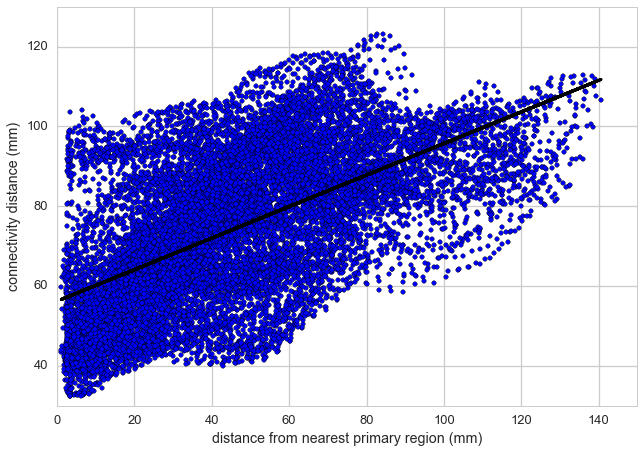

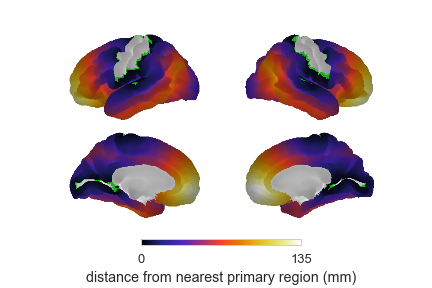

In [5]:
x = np.expand_dims(dist_to_primary_areas_both, axis=1)
y = np.expand_dims(meanDist_areas_both, axis=1)



print '\n\nhemispheres combined, used ćortical areas to define primary regions'

regr = linear_model.LinearRegression()
regr.fit(x, y)

print('Coefficients: \n', regr.coef_)
# The mean square error
print("Residual sum of squares: %.2f"
      % np.mean((regr.predict(x) - y) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(x, y))


f, ax = plt.subplots()
plt.scatter(x, y)
plt.plot(x, regr.predict(x), color='black', linewidth=3)
ax.set_ylabel('connectivity distance (mm)')
ax.set_xlabel('distance from nearest primary region (mm)')
plt.axis((0,150, 30, 130))
plt.show()

cort_lh = np.sort(nib.freesurfer.io.read_label('%s/fsaverage5/label/%s.cortex.label' % (fsDir, 'lh')))
cort_rh = np.sort(nib.freesurfer.io.read_label('%s/fsaverage5/label/%s.cortex.label' % (fsDir, 'rh')))

mask_lh = [x for x in cort_lh if x not in dist_to_primary_areas_both_labels[0]]
mask_rh = [x for x in cort_rh if x not in dist_to_primary_areas_both_labels[1]]


create_fig_both(data=(dist_to_primary_areas_both_surf[0], dist_to_primary_areas_both_surf[1]),
                label_col='green', 
                cpal=None,
                labels=([dist_to_primary_areas_both_labels[0]], [dist_to_primary_areas_both_labels[1]]),
                #labels=([], []),
                surf='pial', cmap='CMRmap', 
                dmin=0, dmax=135, 
                #sulc=None, 
                cbar=True,
                mask=(mask_lh, mask_rh),
               cbar_label='distance from nearest primary region (mm)')

In [11]:
create_fig_both(data=(dist_to_primary_areas_both_surf[0], dist_to_primary_areas_both_surf[1]),
                label_col='green', 
                cpal=None,
                labels=([dist_to_primary_areas_both_labels[0]], [dist_to_primary_areas_both_labels[1]]),
                #labels=([], []),
                surf='inflated', cmap='CMRmap', 
                dmin=0, dmax=135, 
                sulc=True, 
                cbar=True,
                mask=(cort_lh, cort_rh),
               cbar_label='distance from nearest primary region (mm)')

TypeError: create_fig_both() got an unexpected keyword argument 'label_col'

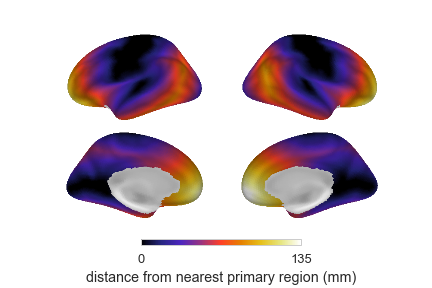

In [13]:
create_fig_both(data=(dist_to_primary_areas_both_surf[0], dist_to_primary_areas_both_surf[1]),
                #label_col='green', 
                cpal=None,
                #labels=([dist_to_primary_areas_both_labels[0]], [dist_to_primary_areas_both_labels[1]]),
                #labels=([], []),
                surf='inflated', cmap='CMRmap', 
                dmin=0, dmax=135, 
                sulc=True, 
                cbar=True,
                mask=(cort_lh, cort_rh),
               cbar_label='distance from nearest primary region (mm)')

In [8]:
regr.predict(x).shape

(16808, 1)

In [ ]:
f, ax = plt.subplots()
plt.scatter(x, y)
plt.plot(x, regr.predict(x), color='black', linewidth=3)
ax.set_ylabel('connectivity distance (mm)')
ax.set_xlabel('distance from nearest primary region (mm)')
plt.axis((0,150, 30, 130))
plt.show()


In [ ]:
x = 0.3 + 0.3 * np.random.randn(10000)
y = 0.1 - 0.2 * x + 0.1 * np.random.randn(10000)
mask = (y > 0) & (x > 0)
x, y = x[mask], y[mask]

g = sns.jointplot(x, y, kind="hex", color="#5d5d60",
                  joint_kws={'gridsize':40, 'bins':'log'})
sns.regplot(x, y, ax=g.ax_joint, scatter=False)

In [15]:
x.squeeze().shape

(16808,)

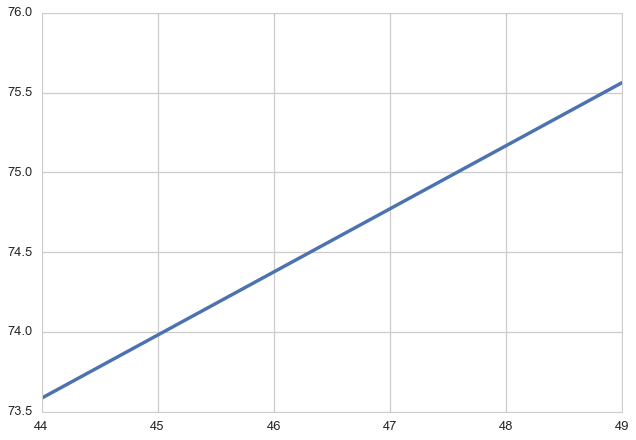

In [16]:
sns.regplot(x.squeeze(), regr.predict(x).squeeze(), scatter=False)

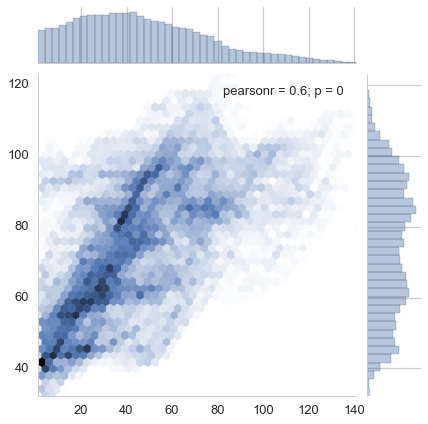

In [19]:
g = sns.jointplot(x, y, kind="hex")

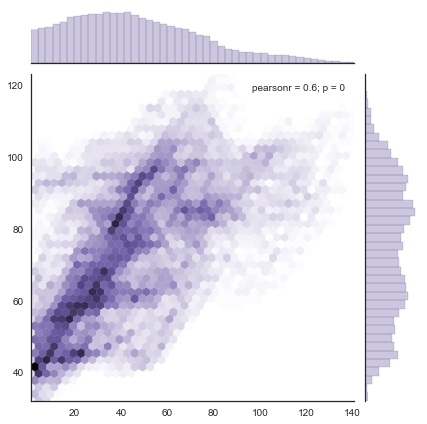

In [49]:
g = sns.jointplot(x.squeeze(), y.squeeze(), kind="hex", color='m')

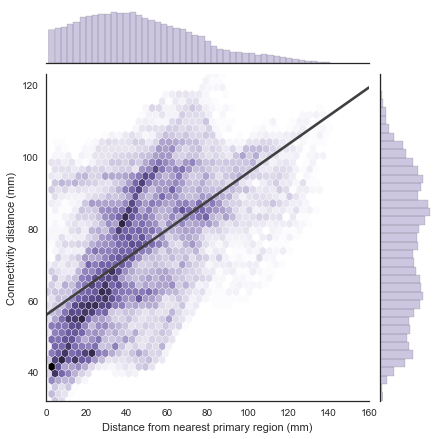

In [77]:
sns.set(style="white", color_codes=True)

g = (sns.jointplot(x, y, kind="hex", stat_func=None, color='m', edgecolor='w')
     .set_axis_labels('Distance from nearest primary region (mm)', 
                      'Connectivity distance (mm)'))

#plt.ylabel('test', fontsize=17)
#plt.yticks(fontsize=15)

sns.regplot(x.squeeze(), regr.predict(x).squeeze(), ax=g.ax_joint, scatter=False, color='0.25')

In [65]:
pear_corr

0.59517059765129499

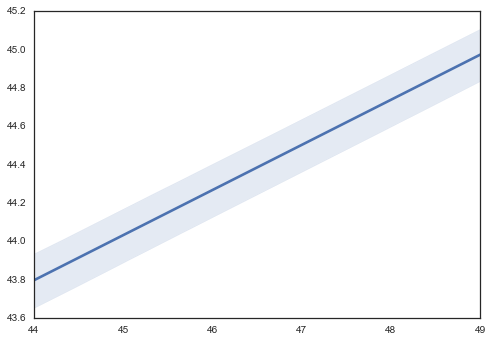

In [64]:
import scipy

pear_corr = scipy.stats.pearsonr(x,y)[0][0]
pred = y.squeeze() * pear_corr

sns.regplot(x.squeeze(), pred, scatter=False)

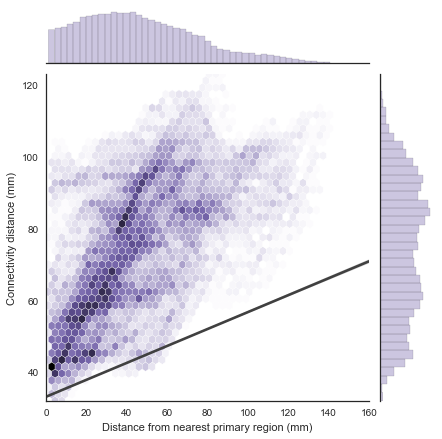

In [62]:
sns.set(style="white", color_codes=True)

g = (sns.jointplot(x, y, kind="hex", stat_func=None, color='m', edgecolor='w')
     .set_axis_labels('Distance from nearest primary region (mm)', 
                      'Connectivity distance (mm)'))

sns.regplot(x.squeeze(), pred, ax=g.ax_joint, scatter=False, color='0.25')

In [66]:
par = np.polyfit(x.squeeze(), y.squeeze(), 1, full=True)

In [68]:
par[0][0]

0.39535570286914545

## separate scatter plots per sensory modality

('Coefficients: \n', array([[ 0.67420276]]))
Residual sum of squares: 68.97
Variance score: 0.75


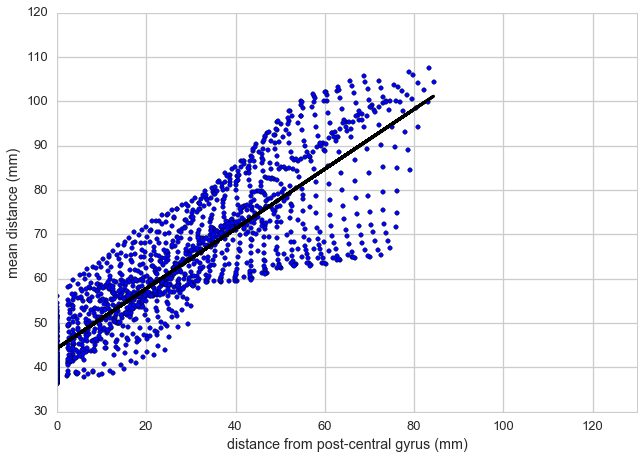

('Coefficients: \n', array([[ 0.25563048]]))
Residual sum of squares: 232.55
Variance score: 0.23


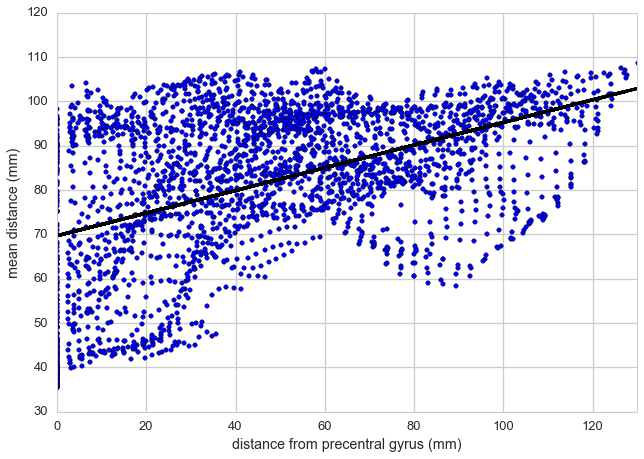

('Coefficients: \n', array([[ 0.37539565]]))
Residual sum of squares: 210.27
Variance score: 0.27


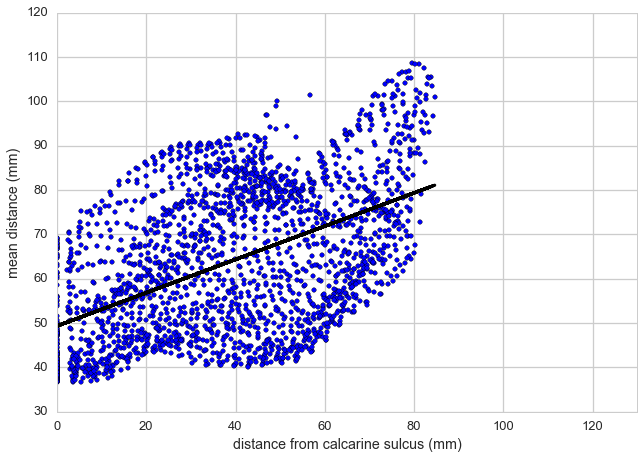

('Coefficients: \n', array([[ 0.74122973]]))
Residual sum of squares: 72.71
Variance score: 0.61


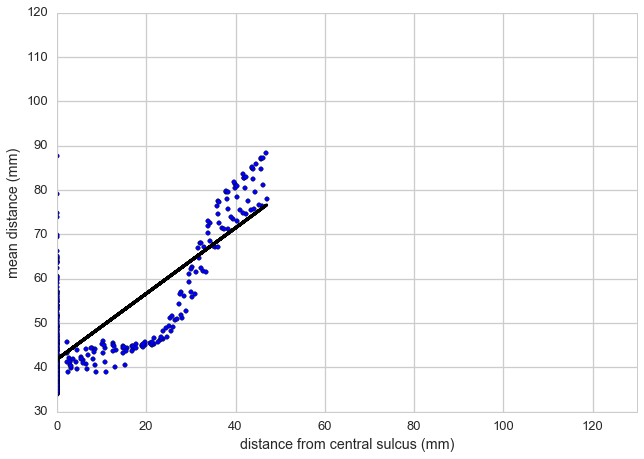

('Coefficients: \n', array([[ 0.44939872]]))
Residual sum of squares: 161.88
Variance score: 0.50


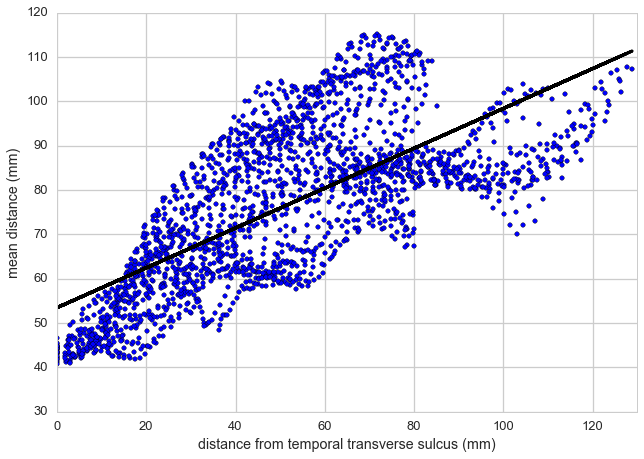

In [100]:
hemi = 'lh'
sns.set_style('whitegrid')


for n_roi, roi in enumerate(['G_postcentral', 'G_precentral', 'S_calcarine',
                            'S_central', 'S_temporal_transverse']):

    
    primary_names = ['post-central gyrus', 'precentral gyrus', 'calcarine sulcus',
                    'central sulcus', 'temporal transverse sulcus']
    
    
    primary_cortices = ['G_postcentral',
                        'G_precentral',
                        'S_calcarine',
                        'S_central',
                        'S_temporal_transverse']
    primary_cortices.remove(roi)

    # component labels ('annot format') and group distance
    if hemi == 'lh':
        gr_dist = gr_dist_lh
    if hemi == 'rh':
        gr_dist = gr_dist_rh
    cort = np.sort(nib.freesurfer.io.read_label('%s/fsaverage5/label/%s.cortex.label' % (fsDir, hemi)))

    # mean distance map
    meanDist = df_mm[['mean distance (geodesic) - group mean']][
                    df_mm['hemisphere'] == hemi].as_matrix().squeeze()


    roi_labels = map(int, list(set(df['node'][(df['region in Destrieux Atlas']==roi)
                                        & (df['hemisphere']==hemi)])))



    primary_area_labels = []
    for area in primary_cortices:
        temp = map(int, list(set(df['node'][(df['region in Destrieux Atlas']==area)
                                                & (df['hemisphere']==hemi)])))
        primary_area_labels.extend(np.sort(np.array(temp)))

    roi_dist = np.array([min(gr_dist[node][roi_labels]) for node in cort])
    others_dist = np.array([min(gr_dist[node][primary_area_labels]) for node in cort])
    roi_closest = np.array([1 if roi_dist[node] < others_dist[node] else 0 for node in range(len(cort))])

    x = np.expand_dims(roi_dist[np.where(roi_closest == 1)[0]], axis=1)
    y = np.expand_dims(meanDist[cort][np.where(roi_closest == 1)[0]], axis=1)
    
    
    regr = linear_model.LinearRegression()
    regr.fit(x, y)

    print('Coefficients: \n', regr.coef_)
    # The mean square error
    print("Residual sum of squares: %.2f"
          % np.mean((regr.predict(x) - y) ** 2))
    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.2f' % regr.score(x, y))
    
    
    
    f, ax = plt.subplots()
    plt.scatter(x, y)
    plt.plot(x, regr.predict(x), color='black', linewidth=3)
    ax.set_ylabel('mean distance (mm)')
    ax.set_xlabel('distance from %s (mm)' % primary_names[n_roi])
    plt.axis((0,130, 30, 120))
    plt.show()



hemispheres combined, used ćortical areas to define primary regions


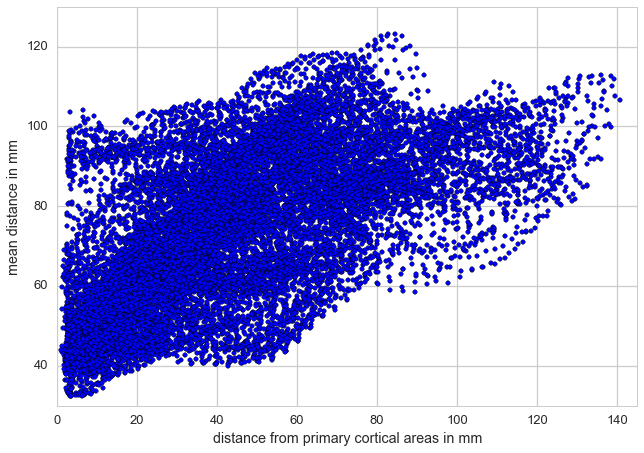

In [35]:
print '\n\nhemispheres combined, used ćortical areas to define primary regions'
sns.set_style('whitegrid')
f, ax = plt.subplots()
plt.scatter(dist_to_primary_areas_both, meanDist_areas_both)
ax.set_ylabel('mean distance in mm')
ax.set_xlabel('distance from primary cortical areas in mm')
plt.axis((0,145, 30, 130))
plt.show()

## old stuff



lh
used largest component to define association regions


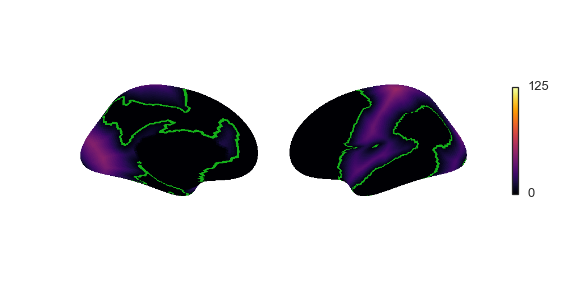

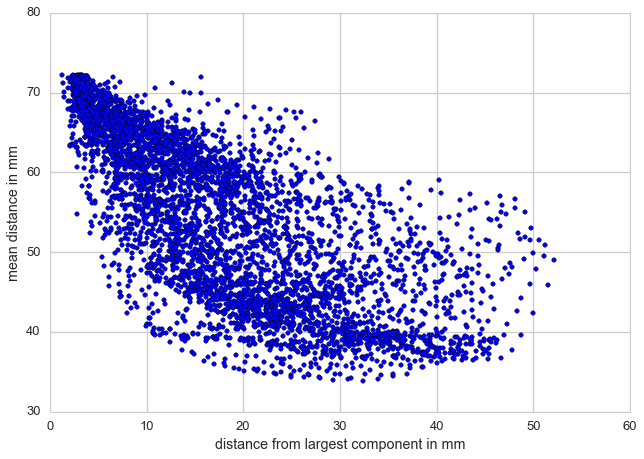



rh
used largest component to define association regions


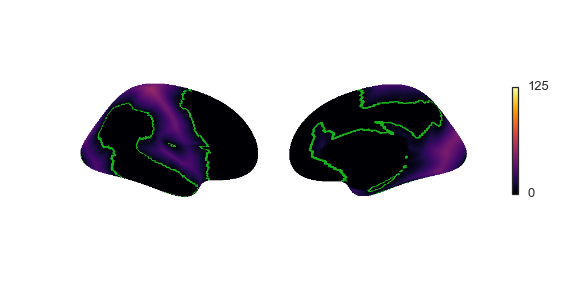

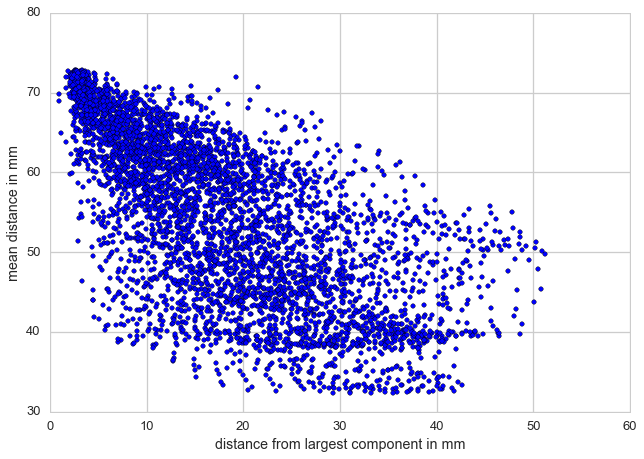



hemispheres combined


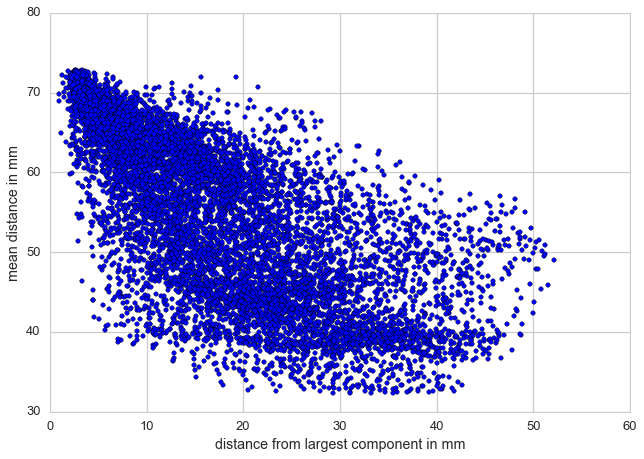

In [265]:
dist_to_primary_comp_both = []
meanDist_comp_both =[]

for hemi in ['lh', 'rh']:
    print '\n\n%s' % hemi
    
    # component labels ('annot format') and group distance
    if hemi == 'lh':
        comp_labels = [np.where(comp_labels_lh == comp)[0] for comp in range(1,n_comp+1)]
        gr_dist = gr_dist_lh
    if hemi == 'rh':
        comp_labels = [np.where(comp_labels_rh == comp)[0] for comp in range(1,n_comp+1)]
        gr_dist = gr_dist_rh
    
    
    # mean distance map
    meanDist = df_mm[['mean distance (geodesic) - group mean']][df_mm['hemisphere'] == hemi].as_matrix().squeeze()
     
    # distance to primary component
    comp_order = np.argsort([meanDist[comp_labels[comp]].mean() for comp in range(n_comp)])  
    primary_comp_labels = comp_labels[comp_order[2]]
    rest_comp_labels = np.sort(np.concatenate((comp_labels[comp_order[1]],comp_labels[comp_order[0]])))
    dist_to_primary_comp = np.array([min(gr_dist[node][primary_comp_labels]) for node in range((10242))])
    
    
    # transition map of mean distance
    #trmap = create_trmap(meanDist, hemi)
    
    # combine distance maps from hemis
    dist_to_primary_comp_both.extend(list(dist_to_primary_comp[rest_comp_labels]))
    meanDist_comp_both.extend(list(meanDist[rest_comp_labels]))
    
    
    
    # plots
    sns.set_style('white')

    
    print 'used largest component to define association regions'
    create_fig(data=dist_to_primary_comp, labels=[primary_comp_labels], label_col='green', hemi=hemi, surf='inflated', 
               cmap='inferno', sulc=False,cbar=True, dmin=0, dmax=125) #dmax=np.percentile(trmap, 95)
    sns.set_style('whitegrid')
    f, ax = plt.subplots()
    plt.scatter(dist_to_primary_comp[rest_comp_labels], meanDist[rest_comp_labels])
    ax.set_ylabel('mean distance in mm')
    ax.set_xlabel('distance from largest component in mm')
    plt.axis((0,60, 30, 80))
    plt.show()
    
    
# combine hemispheres
    
print '\n\nhemispheres combined'
sns.set_style('whitegrid')
f, ax = plt.subplots()
plt.scatter(dist_to_primary_comp_both, meanDist_comp_both)
ax.set_ylabel('mean distance in mm')
ax.set_xlabel('distance from largest component in mm')
plt.axis((0,60, 30, 80))
plt.show()





lh
used middle component to define association regions


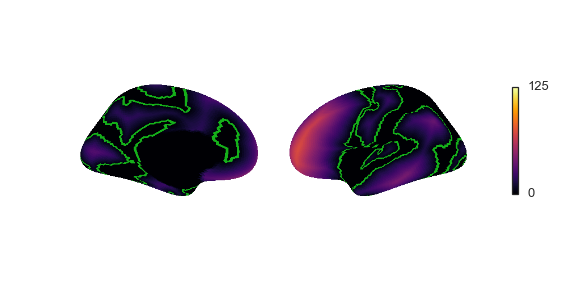

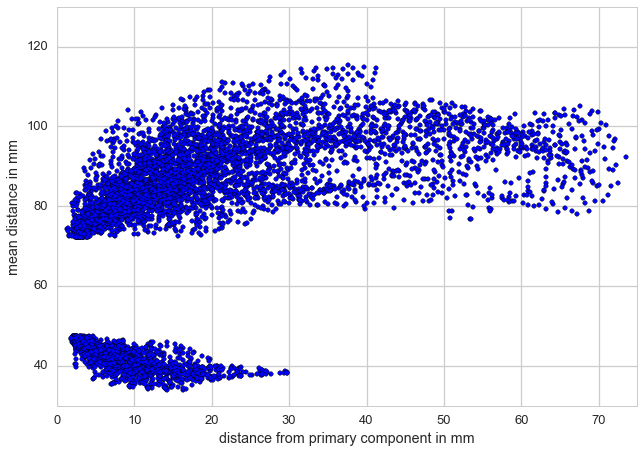



rh
used middle component to define association regions


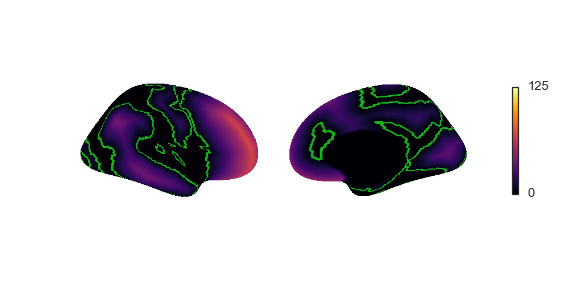

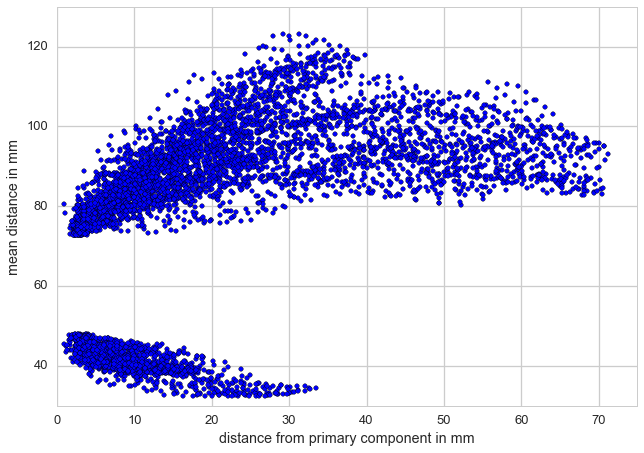



hemispheres combined


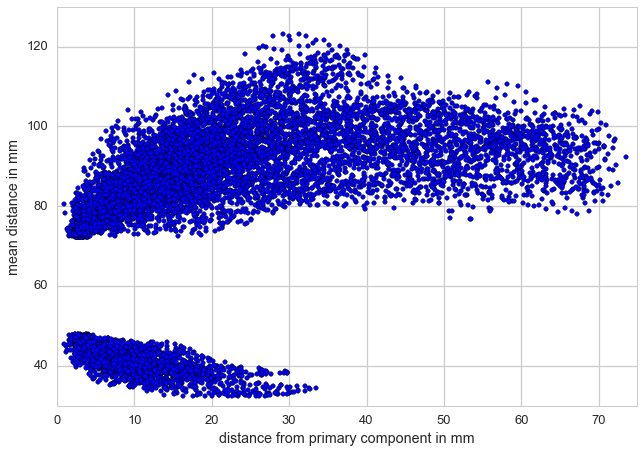

In [264]:
dist_to_primary_comp_both = []
meanDist_comp_both =[]

for hemi in ['lh', 'rh']:
    print '\n\n%s' % hemi
    
    # component labels ('annot format') and group distance
    if hemi == 'lh':
        comp_labels = [np.where(comp_labels_lh == comp)[0] for comp in range(1,n_comp+1)]
        gr_dist = gr_dist_lh
    if hemi == 'rh':
        comp_labels = [np.where(comp_labels_rh == comp)[0] for comp in range(1,n_comp+1)]
        gr_dist = gr_dist_rh
    
    
    # mean distance map
    meanDist = df_mm[['mean distance (geodesic) - group mean']][df_mm['hemisphere'] == hemi].as_matrix().squeeze()
     
    # distance to primary component
    comp_order = np.argsort([meanDist[comp_labels[comp]].mean() for comp in range(n_comp)])  
    primary_comp_labels = comp_labels[comp_order[1]]
    rest_comp_labels = np.sort(np.concatenate((comp_labels[comp_order[2]],comp_labels[comp_order[0]])))
    dist_to_primary_comp = np.array([min(gr_dist[node][primary_comp_labels]) for node in range((10242))])
    
    
    # transition map of mean distance
    #trmap = create_trmap(meanDist, hemi)
    
    # combine distance maps from hemis
    dist_to_primary_comp_both.extend(list(dist_to_primary_comp[rest_comp_labels]))
    meanDist_comp_both.extend(list(meanDist[rest_comp_labels]))
    
    
    
    # plots
    sns.set_style('white')

    
    print 'used middle component to define association regions'
    create_fig(data=dist_to_primary_comp, labels=[primary_comp_labels], label_col='green', hemi=hemi, surf='inflated', 
               cmap='inferno', sulc=False,cbar=True, dmin=0, dmax=125) #dmax=np.percentile(trmap, 95)
    sns.set_style('whitegrid')
    f, ax = plt.subplots()
    plt.scatter(dist_to_primary_comp[rest_comp_labels], meanDist[rest_comp_labels])
    ax.set_ylabel('mean distance in mm')
    ax.set_xlabel('distance from  component in mm')
    plt.axis((0,75, 30, 130))
    plt.show()
    
    
# combine hemispheres
    
print '\n\nhemispheres combined'
sns.set_style('whitegrid')
f, ax = plt.subplots()
plt.scatter(dist_to_primary_comp_both, meanDist_comp_both)
ax.set_ylabel('mean distance in mm')
ax.set_xlabel('distance from middle component in mm')
plt.axis((0,75, 30, 130))
plt.show()



In [40]:
n_comp = 7
comp_labels_rh = np.load('%s/clustering/clust_%icomp_rh.npy' % (resDir,n_comp))
comp_labels_lh = np.load('%s/clustering/clust_%icomp_lh.npy' % (resDir,n_comp))

1


lh


/scr/ilz1/cbspython_surf/surfenv/lib/python2.7/site-packages/ipykernel/__main__.py:31: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


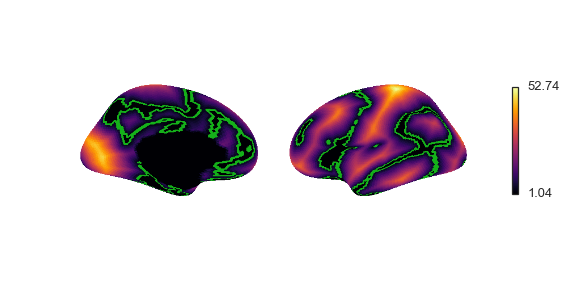



rh


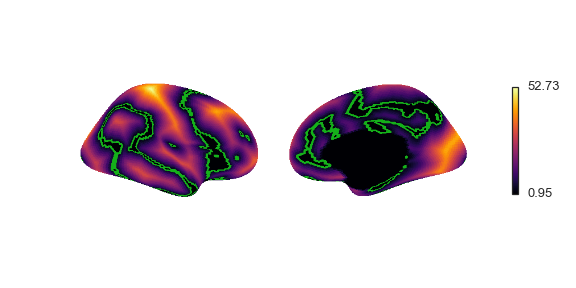



hemispheres combined
0.102219850652


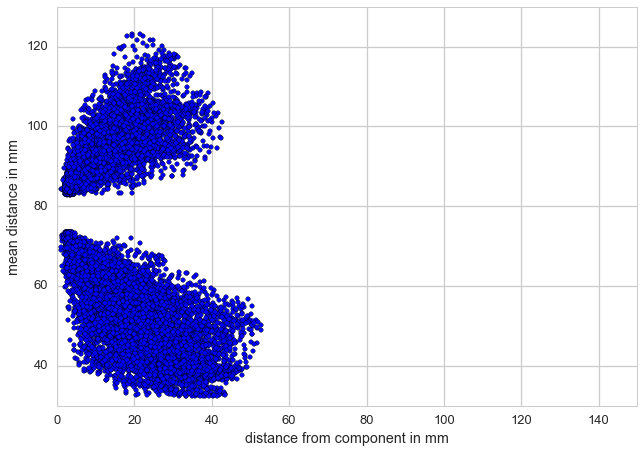

2


lh


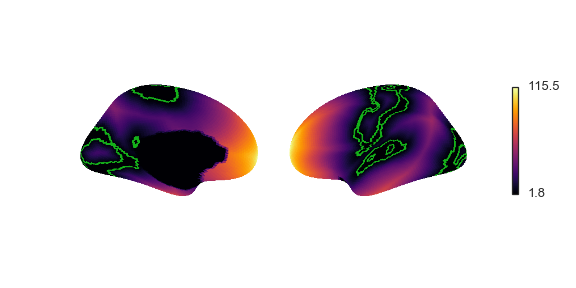



rh


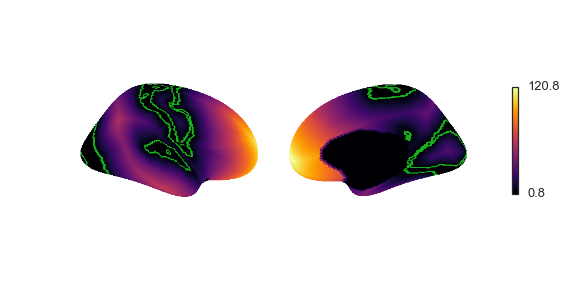



hemispheres combined
0.654906843412


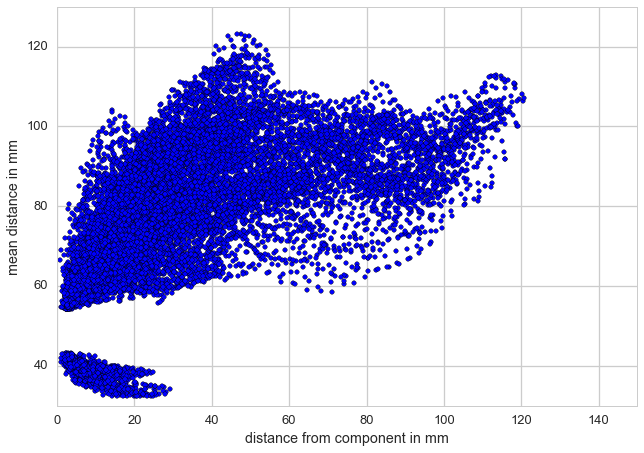

3


lh


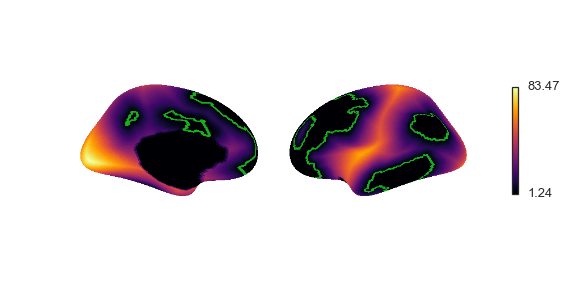



rh


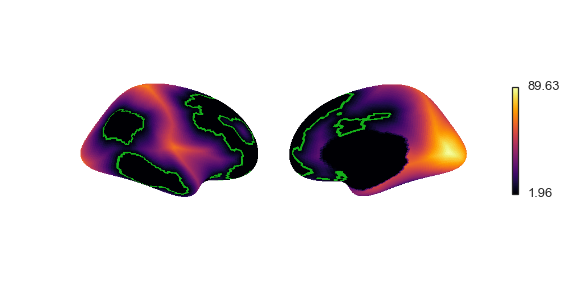



hemispheres combined
-0.00586916437421


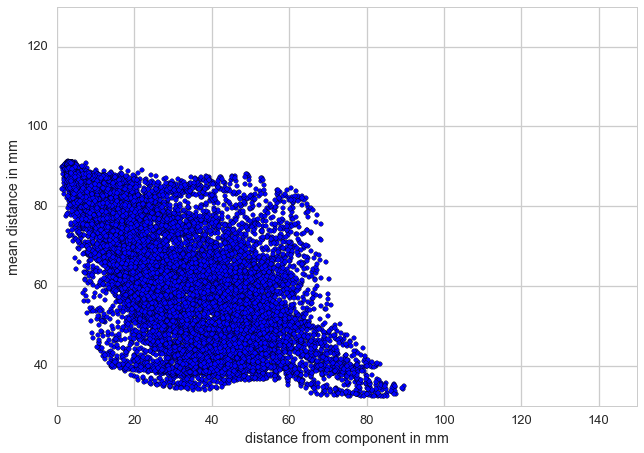

4


lh


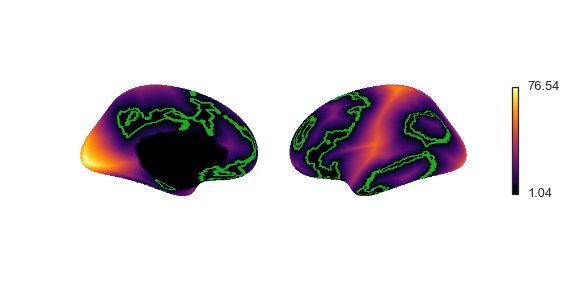



rh


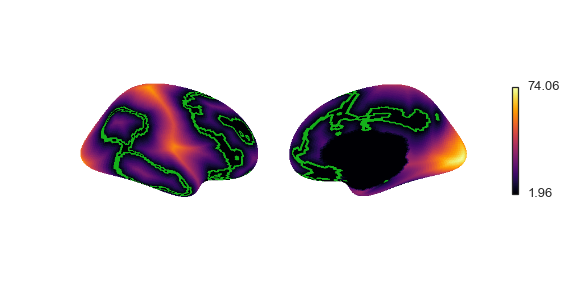



hemispheres combined
-0.141020778058


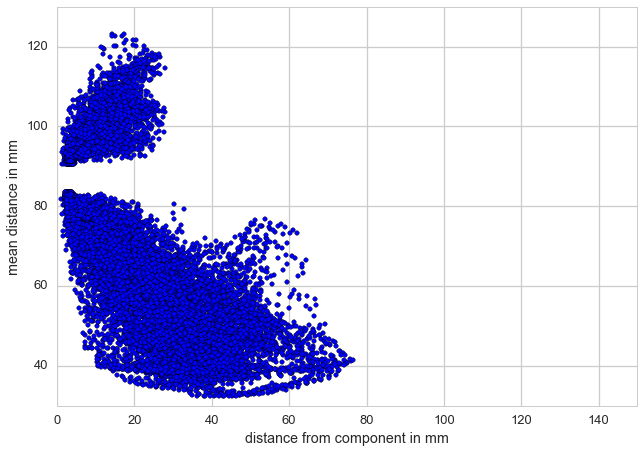

5


lh


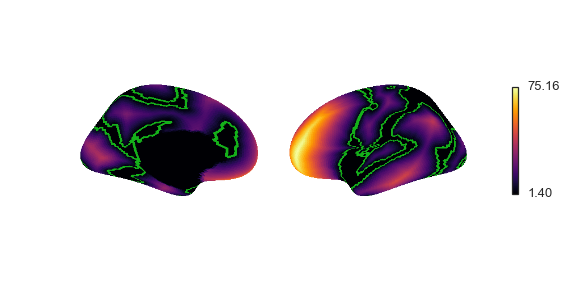



rh


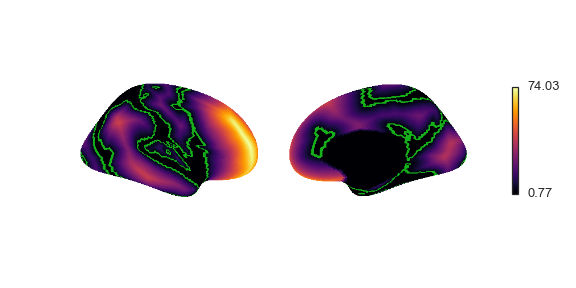



hemispheres combined
0.594590930127


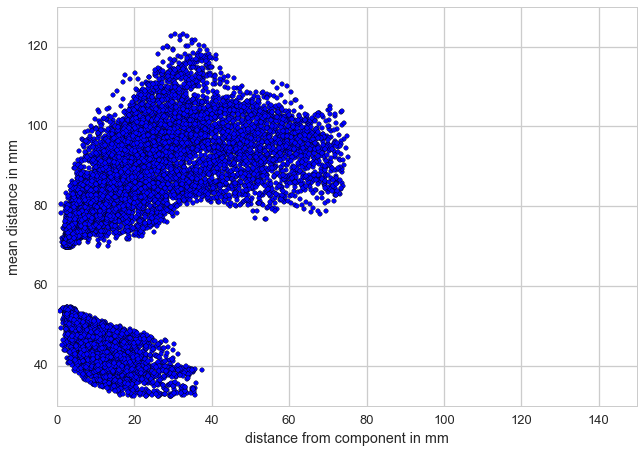

6


lh


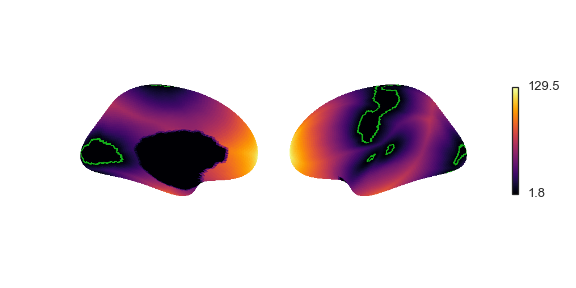



rh


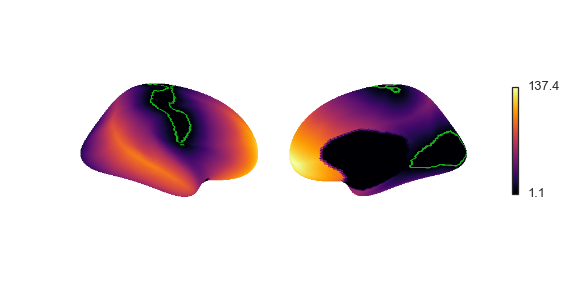



hemispheres combined
0.721668761033


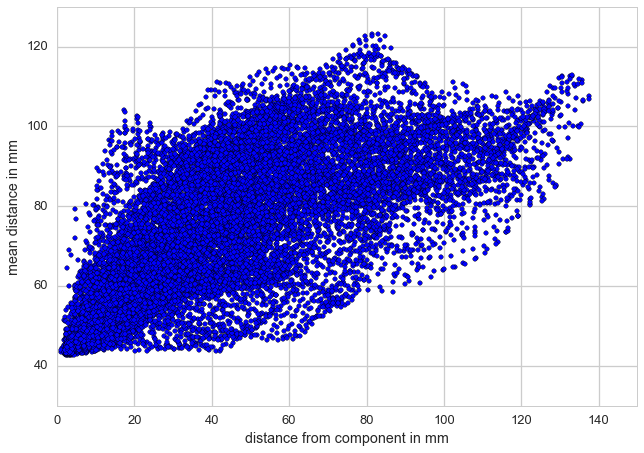

7


lh


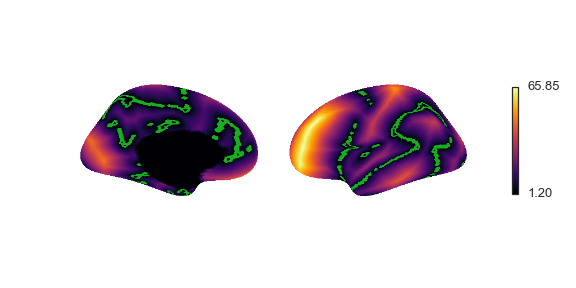



rh


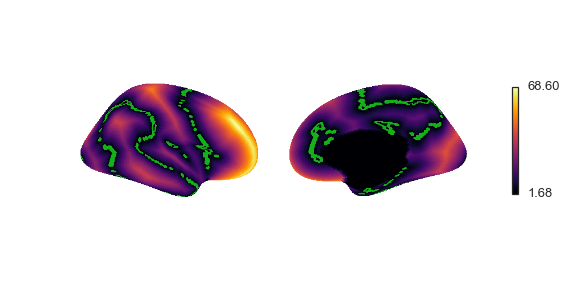



hemispheres combined
0.396035101919


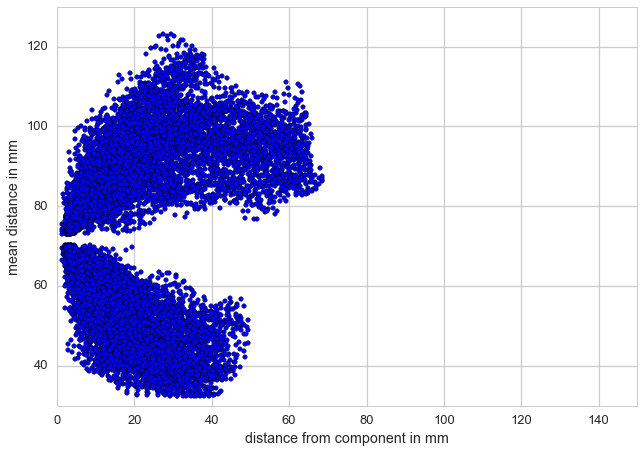

In [330]:

corr_r = []

for i in np.nonzero(np.unique(comp_labels_lh))[0]:
    
    print i

    dist_to_primary_comp_both = []
    meanDist_comp_both =[]

    for hemi in ['lh', 'rh']:
        print '\n\n%s' % hemi

        # component labels ('annot format') and group distance
        if hemi == 'lh':
            #comp_labels = [np.where(comp_labels_lh == comp)[0] for comp in range(1,n_comp+1)]
            comp_labels = comp_labels_lh
            gr_dist = gr_dist_lh
        if hemi == 'rh':
            #comp_labels = [np.where(comp_labels_rh == comp)[0] for comp in range(1,n_comp+1)]
            comp_labels = comp_labels_rh
            gr_dist = gr_dist_rh


        # mean distance map
        meanDist = df_mm[['mean distance (geodesic) - group mean']][df_mm['hemisphere'] == hemi].as_matrix().squeeze()

        # distance to primary component
        comp_order = np.argsort([meanDist[comp_labels[comp]].mean() for comp in range(n_comp)])
        primary_comp_labels = np.where(comp_labels==i)[0]
        rest_comp_labels = np.where(comp_labels!=(i or 0))[0]
        dist_to_primary_comp = np.array([min(gr_dist[node][primary_comp_labels]) for node in range((10242))])


        # transition map of mean distance
        #trmap = create_trmap(meanDist, hemi)

        # combine distance maps from hemis
        dist_to_primary_comp_both.extend(list(dist_to_primary_comp[rest_comp_labels]))
        meanDist_comp_both.extend(list(meanDist[rest_comp_labels]))



        # plots
        sns.set_style('white')


        create_fig(data=dist_to_primary_comp, labels=[primary_comp_labels], label_col='green', hemi=hemi, surf='inflated', 
                   cmap='inferno', sulc=False,cbar=True)#, dmin=0, dmax=125) #dmax=np.percentile(trmap, 95)
        '''
        sns.set_style('whitegrid')
        f, ax = plt.subplots()
        plt.scatter(dist_to_primary_comp[rest_comp_labels], meanDist[rest_comp_labels])
        ax.set_ylabel('mean distance in mm')
        ax.set_xlabel('distance from  component in mm')
        plt.axis((0,75, 30, 130))
        plt.show()
        '''

    # combine hemispheres

    print '\n\nhemispheres combined'
    r = np.corrcoef(dist_to_primary_comp_both, meanDist_comp_both)[0, 1]
    print r
    corr_r.append(r)
    sns.set_style('whitegrid')
    f, ax = plt.subplots()
    plt.scatter(dist_to_primary_comp_both, meanDist_comp_both)
    ax.set_ylabel('mean distance in mm')
    ax.set_xlabel('distance from component in mm')
    plt.axis((0,150, 30, 130))
    plt.show()



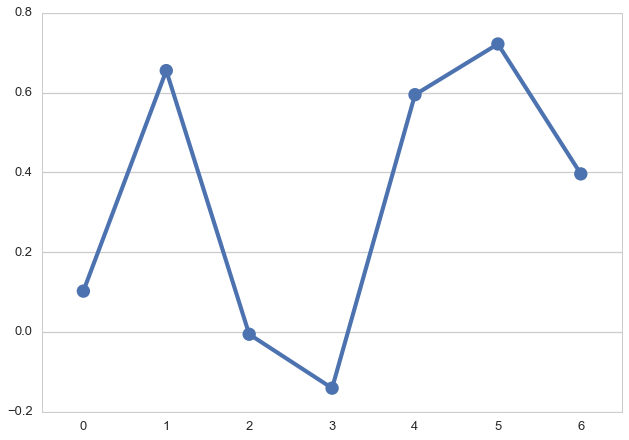

In [344]:
sns.set_style('whitegrid')
f, ax = plt.subplots()

sns.pointplot(range(len(corr_r)), corr_r)

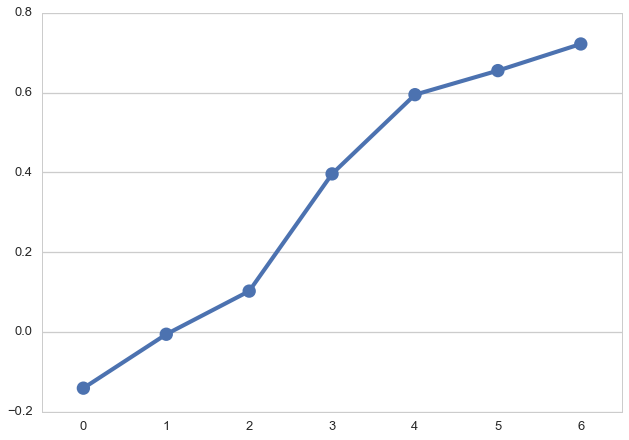

In [342]:
sns.set_style('whitegrid')
f, ax = plt.subplots()

sns.pointplot(range(len(corr_r)), np.array(corr_r)[np.argsort(corr_r)])



In [345]:
np.nonzero(np.unique(comp_labels_lh))[0][np.argsort(corr_r)]

array([4, 3, 1, 7, 5, 2, 6])

6


lh


/scr/ilz1/cbspython_surf/surfenv/lib/python2.7/site-packages/ipykernel/__main__.py:31: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


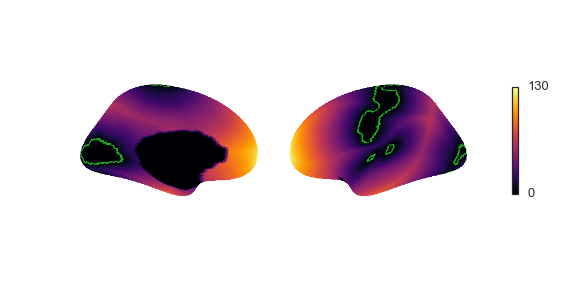



rh


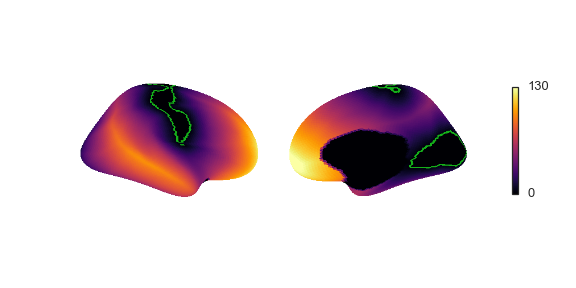



hemispheres combined
0.721668761033


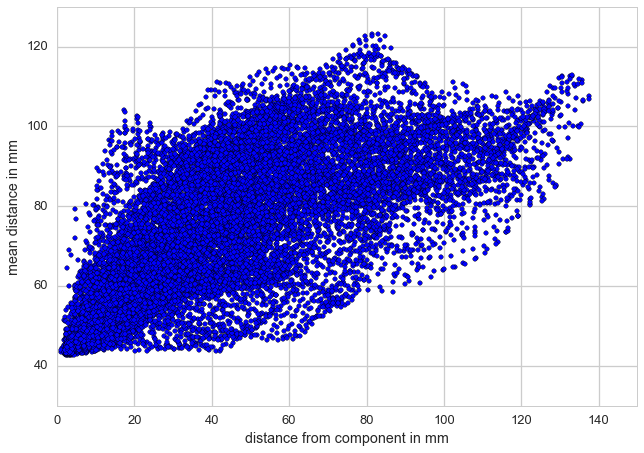

In [347]:

for i in [6]:
    
    print i

    dist_to_primary_comp_both = []
    meanDist_comp_both =[]

    for hemi in ['lh', 'rh']:
        print '\n\n%s' % hemi

        # component labels ('annot format') and group distance
        if hemi == 'lh':
            #comp_labels = [np.where(comp_labels_lh == comp)[0] for comp in range(1,n_comp+1)]
            comp_labels = comp_labels_lh
            gr_dist = gr_dist_lh
        if hemi == 'rh':
            #comp_labels = [np.where(comp_labels_rh == comp)[0] for comp in range(1,n_comp+1)]
            comp_labels = comp_labels_rh
            gr_dist = gr_dist_rh


        # mean distance map
        meanDist = df_mm[['mean distance (geodesic) - group mean']][df_mm['hemisphere'] == hemi].as_matrix().squeeze()

        # distance to primary component
        comp_order = np.argsort([meanDist[comp_labels[comp]].mean() for comp in range(n_comp)])
        primary_comp_labels = np.where(comp_labels==i)[0]
        rest_comp_labels = np.where(comp_labels!=(i or 0))[0]
        dist_to_primary_comp = np.array([min(gr_dist[node][primary_comp_labels]) for node in range((10242))])


        # transition map of mean distance
        #trmap = create_trmap(meanDist, hemi)

        # combine distance maps from hemis
        dist_to_primary_comp_both.extend(list(dist_to_primary_comp[rest_comp_labels]))
        meanDist_comp_both.extend(list(meanDist[rest_comp_labels]))



        # plots
        sns.set_style('white')


        create_fig(data=dist_to_primary_comp, labels=[primary_comp_labels], label_col='green', hemi=hemi, surf='inflated', 
                   cmap='inferno', sulc=False,cbar=True, dmin=0, dmax=130) #dmax=np.percentile(trmap, 95)
        '''
        sns.set_style('whitegrid')
        f, ax = plt.subplots()
        plt.scatter(dist_to_primary_comp[rest_comp_labels], meanDist[rest_comp_labels])
        ax.set_ylabel('mean distance in mm')
        ax.set_xlabel('distance from  component in mm')
        plt.axis((0,75, 30, 130))
        plt.show()
        '''

    # combine hemispheres

    print '\n\nhemispheres combined'
    r = np.corrcoef(dist_to_primary_comp_both, meanDist_comp_both)[0, 1]
    print r
    corr_r.append(r)
    sns.set_style('whitegrid')
    f, ax = plt.subplots()
    plt.scatter(dist_to_primary_comp_both, meanDist_comp_both)
    ax.set_ylabel('mean distance in mm')
    ax.set_xlabel('distance from component in mm')
    plt.axis((0,150, 30, 130))
    plt.show()





lh


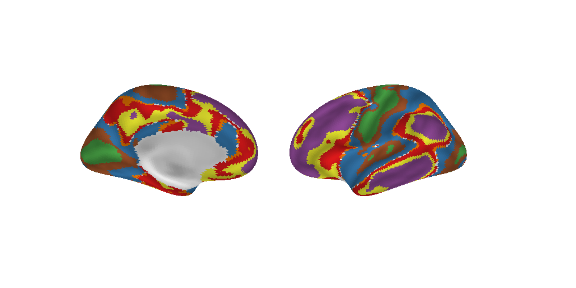



rh


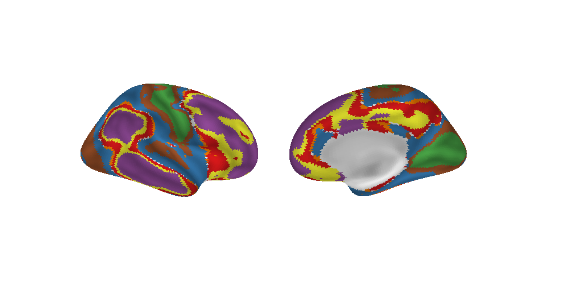

In [41]:

for hemi in ['lh', 'rh']:
    print '\n\n%s' % hemi
    
    # component labels ('annot format') and group distance
    if hemi == 'lh':
        comp_labels = [np.where(comp_labels_lh == comp)[0] for comp in range(1,n_comp+1)]
        gr_dist = gr_dist_lh
    if hemi == 'rh':
        comp_labels = [np.where(comp_labels_rh == comp)[0] for comp in range(1,n_comp+1)]
        gr_dist = gr_dist_rh
    
    
    # mean distance map
    meanDist = df_mm[['mean distance (geodesic) - group mean']][df_mm['hemisphere'] == hemi].as_matrix().squeeze()
     
    # transition map of mean distance
    #trmap = create_trmap(meanDist, hemi)
    
    # plots
    sns.set_style('white')
    
    create_fig(labels=comp_labels, hemi=hemi, surf='inflated', cbar=True, cpal='Set1')
    #create_fig(data=trmap, labels=comp_labels, label_col='green', hemi=hemi, surf='inflated', 
    #           cmap='inferno', dmin=0, dmax=7.5, sulc=False,cbar=True) #dmax=np.percentile(trmap, 95)
    
    

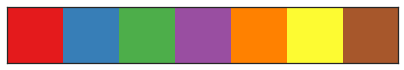

In [5]:
sns.palplot(sns.color_palette('Set1', 7))

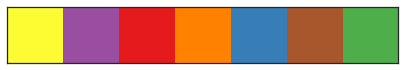

In [38]:
order=[5, 3, 0, 4, 1, 6, 2]
pal = sns.color_palette(sns.color_palette('Set1', 7))
sns.palplot(np.array(pal)[order,:])

In [9]:
np.array(test)[3, 2, 0, 6, 4, 1, 5]

IndexError: too many indices for array

In [23]:
n_comp = 3
comp_labels_rh = np.load('%s/clustering/clust_%icomp_rh.npy' % (resDir,n_comp))
comp_labels_lh = np.load('%s/clustering/clust_%icomp_lh.npy' % (resDir,n_comp))



lh


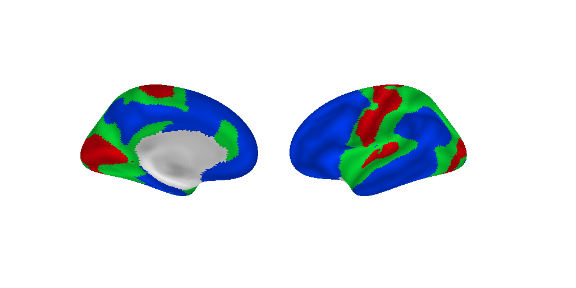



rh


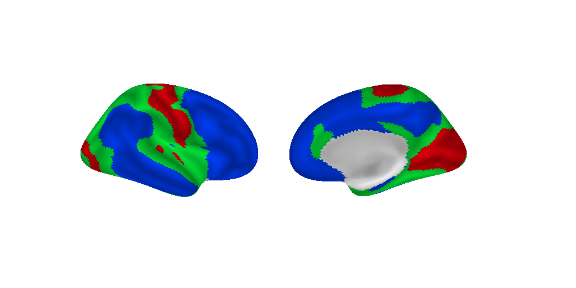

In [37]:

for hemi in ['lh', 'rh']:
    print '\n\n%s' % hemi
    
    # component labels ('annot format') and group distance
    if hemi == 'lh':
        #comp_labels = [np.where(comp_labels_lh == comp)[0] for comp in range(1,n_comp+1)]
        comp_labels = [np.where(comp_labels_lh == comp)[0] for comp in [2,1,3]]
        gr_dist = gr_dist_lh
    if hemi == 'rh':
        #comp_labels = [np.where(comp_labels_rh == comp)[0] for comp in range(1,n_comp+1)]
        comp_labels = [np.where(comp_labels_rh == comp)[0] for comp in [2,1,3]]
        gr_dist = gr_dist_rh
    
    
    # mean distance map
    meanDist = df_mm[['mean distance (geodesic) - group mean']][df_mm['hemisphere'] == hemi].as_matrix().squeeze()
     
    # transition map of mean distance
    #trmap = create_trmap(meanDist, hemi)
    
    # plots
    sns.set_style('white')
    
    create_fig(labels=comp_labels, hemi=hemi, surf='inflated', cbar=True)#, cpal='Set1')
    #create_fig(data=trmap, labels=comp_labels, label_col='green', hemi=hemi, surf='inflated', 
               #cmap='inferno', dmin=0, dmax=7.5, sulc=False,cbar=True) #dmax=np.percentile(trmap, 95)
    
    

In [32]:
# lighter background plotting (doesnt work from plotting.py for some reason... )

'''
Functions for plotting surfaces with pure python code. 
Reduced version of nilearn surface plotting:
https://github.com/juhuntenburg/nilearn/tree/enh/surface_plotting

Helper function for symmetric colormap is copied from nilearn.
'''

def plot_surf_stat_map(coords, faces, stat_map=None,
                       elev=0, azim=0,
                       cmap='coolwarm',
                       threshold=None, bg_map=None,
                       bg_on_stat=False,
                       alpha='auto',
                       vmin=None, vmax=None,
                       cbar='sequential', # or'diverging'
                       symmetric_cbar="auto",
                       figsize=None,
                       labels=None, label_cpal=None,
                       mask=None, mask_lenient=None,
                       **kwargs):
    
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.tri as tri
    from mpl_toolkits.mplot3d import Axes3D
    import seaborn as sns
    
    # load mesh and derive axes limits
    faces = np.array(faces, dtype=int)
    limits = [coords.min(), coords.max()]

    # set alpha if in auto mode
    if alpha == 'auto':
        if bg_map is None:
            alpha = .5
        else:
            alpha = 1

    # if cmap is given as string, translate to matplotlib cmap
    if type(cmap) == str:
        cmap = plt.cm.get_cmap(cmap)

    # initiate figure and 3d axes
    if figsize is not None:
        fig = plt.figure(figsize=figsize)
    else:
        fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d', xlim=limits, ylim=limits)
    ax.view_init(elev=elev, azim=azim)
    ax.set_axis_off()

    # plot mesh without data
    p3dcollec = ax.plot_trisurf(coords[:, 0], coords[:, 1], coords[:, 2],
                                triangles=faces, linewidth=0.,
                                antialiased=False,
                                color='white')

    # where mask is indices of nodes to include:
    if mask is not None:    
        cmask = np.zeros(len(coords))
        cmask[mask] = 1
        cutoff = 2 # include triangles in cortex only if ALL nodes in mask
        if mask_lenient: # include triangles in cortex if ANY are in mask
            cutoff = 0
        fmask = np.where(cmask[faces].sum(axis=1) > cutoff)[0]    
    
    
    # If depth_map and/or stat_map are provided, map these onto the surface
    # set_facecolors function of Poly3DCollection is used as passing the
    # facecolors argument to plot_trisurf does not seem to work
    if bg_map is not None or stat_map is not None:

        face_colors = np.ones((faces.shape[0], 4))
        face_colors[:, :3] = .5*face_colors[:, :3]

        if bg_map is not None:
            bg_data = bg_map
            if bg_data.shape[0] != coords.shape[0]:
                raise ValueError('The bg_map does not have the same number '
                                 'of vertices as the mesh.')
            bg_faces = np.mean(bg_data[faces], axis=1)
            bg_faces = bg_faces - bg_faces.min()
            bg_faces = bg_faces / bg_faces.max()
            face_colors = plt.cm.gray_r(bg_faces)
            face_colors[:,0:3] = (-0.5)*face_colors[:,0:3]
            face_colors[:,0:3] = 1+face_colors[:,0:3]

        # modify alpha values of background
        face_colors[:, 3] = alpha*face_colors[:, 3]

        if stat_map is not None:
            stat_map_data = stat_map
            stat_map_faces = np.mean(stat_map_data[faces], axis=1)

            if cbar is 'diverging':
                print cbar
                # Call _get_plot_stat_map_params to derive symmetric vmin and vmax
                # And colorbar limits depending on symmetric_cbar settings
                cbar_vmin, cbar_vmax, vmin, vmax = \
                    _get_plot_stat_map_params(stat_map_faces, vmax,
                                              symmetric_cbar, kwargs)
            if cbar is 'sequential':
                if vmin is None:
                    vmin = stat_map_data.min()
                if vmax is None:
                    vmax = stat_map_data.max()

            if threshold is not None:
                kept_indices = np.where(abs(stat_map_faces) >= threshold)[0]
                stat_map_faces = stat_map_faces - vmin
                stat_map_faces = stat_map_faces / (vmax-vmin)
                if bg_on_stat:
                    face_colors[kept_indices] = cmap(stat_map_faces[kept_indices]) * face_colors[kept_indices]
                else:
                    face_colors[kept_indices] = cmap(stat_map_faces[kept_indices])
            else:
                stat_map_faces = stat_map_faces - vmin
                stat_map_faces = stat_map_faces / (vmax-vmin)
                if bg_on_stat:
                    if mask is not None:
                        face_colors[fmask] = cmap(stat_map_faces)[fmask] * face_colors[fmask]
                    else:
                        face_colors = cmap(stat_map_faces) * face_colors
                else:
                    if mask is not None:
                        face_colors[fmask] = cmap(stat_map_faces)[fmask] * face_colors[fmask]
                    else:
                        face_colors = cmap(stat_map_faces)

        if labels is not None:
            '''
            labels requires a tuple of label/s, each a list/array of node indices
            ----------------------------------------------------------------------
            color palette for labels
            if label_cpal is None, outlines will be black
            if it's a color palette name, a different color for each label will be generated
            if it's a list of rgb or color names, these will be used
            valid color names from http://xkcd.com/color/rgb/
            '''
            if label_cpal is not None:
                if type(label_cpal) == str:
                    cpal = sns.color_palette(label_cpal, len(labels))
                if type(label_cpal) == list:
                    if len(label_cpal) < len(labels):
                        raise ValueError('There are not enough colors in the color list.')
                    try:
                        cpal = sns.color_palette(label_cpal)
                    except:
                        cpal = sns.xkcd_palette(label_cpal)
        
            for n_label, label in enumerate(labels):
                for n_face, face in enumerate(faces):
                    count = len(set(face).intersection(set(label)))
                    if (count > 0) & (count < 3):
                        if label_cpal is None:
                            face_colors[n_face,0:3] = sns.xkcd_palette(["black"])[0]
                        else:
                            face_colors[n_face,0:3] = cpal[n_label]
                            
        p3dcollec.set_facecolors(face_colors)

    return fig


def _get_plot_stat_map_params(stat_map_data, vmax, symmetric_cbar, kwargs,
    force_min_stat_map_value=None):
    import numpy as np
    """ Internal function for setting value limits for plot_stat_map and
    plot_glass_brain.
    The limits for the colormap will always be set to range from -vmax to vmax.
    The limits for the colorbar depend on the symmetric_cbar argument, please
    refer to docstring of plot_stat_map.
    """
    # make sure that the color range is symmetrical
    if vmax is None or symmetric_cbar in ['auto', False]:
        # Avoid dealing with masked_array:
        if hasattr(stat_map_data, '_mask'):
            stat_map_data = np.asarray(
                    stat_map_data[np.logical_not(stat_map_data._mask)])
        stat_map_max = np.nanmax(stat_map_data)
        if force_min_stat_map_value == None:
            stat_map_min = np.nanmin(stat_map_data)
        else:
            stat_map_min = force_min_stat_map_value
    if symmetric_cbar == 'auto':
        symmetric_cbar = stat_map_min < 0 and stat_map_max > 0
    if vmax is None:
        vmax = max(-stat_map_min, stat_map_max)
    if 'vmin' in kwargs:
        raise ValueError('this function does not accept a "vmin" '
            'argument, as it uses a symmetrical range '
            'defined via the vmax argument. To threshold '
            'the map, use the "threshold" argument')
    vmin = -vmax
    if not symmetric_cbar:
        negative_range = stat_map_max <= 0
        positive_range = stat_map_min >= 0
        if positive_range:
            cbar_vmin = 0
            cbar_vmax = None
        elif negative_range:
            cbar_vmax = 0
            cbar_vmin = None
        else:
            cbar_vmin = stat_map_min
            cbar_vmax = stat_map_max
    else:
        cbar_vmin, cbar_vmax = None, None
    return cbar_vmin, cbar_vmax, vmin, vmax
    


    
    
    
    
    
def plot_surf_label(coords, faces, 
                    labels=None,
                    elev=0, azim=0,
                    cpal='bright',
                    threshold=None, 
                    bg_map=None,
                    bg_on_labels=False,
                    alpha='auto',
                    figsize=None,
                    **kwargs):
    
    '''
    - labels requires a tuple of label/s, each a list/array of node indices
    - cpal takes either the name of a seaborn color palette or matplotlib color map, 
      or a list of rgb values or color names from http://xkcd.com/color/rgb/
    '''
    
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.tri as tri
    from mpl_toolkits.mplot3d import Axes3D
    import seaborn as sns
    
    # load mesh and derive axes limits
    faces = np.array(faces, dtype=int)
    limits = [coords.min(), coords.max()]

    # set alpha if in auto mode
    if alpha == 'auto':
        if bg_map is None:
            alpha = .5
        else:
            alpha = 1

    # if cap is given as string, translate to seaborn color palette
    if type(cpal) == str:
        cpal = sns.color_palette(cpal, len(labels))
    if type(cpal) == list:
        if len(cpal) < len(labels):
            raise ValueError('There are not enough colors in the color list.')
        try:
            cpal = sns.color_palette(cpal)
        except:
            cpal = sns.xkcd_palette(cpal)
    
    # initiate figure and 3d axes
    if figsize is not None:
        fig = plt.figure(figsize=figsize)
    else:
        fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d', xlim=limits, ylim=limits)
    ax.view_init(elev=elev, azim=azim)
    ax.set_axis_off()

    # plot mesh without data
    p3dcollec = ax.plot_trisurf(coords[:, 0], coords[:, 1], coords[:, 2],
                                triangles=faces, linewidth=0.,
                                antialiased=False,
                                color='white')

    if bg_map is not None or labels is not None:

        face_colors = np.ones((faces.shape[0], 4))
        face_colors[:, :3] = .5*face_colors[:, :3]

        if bg_map is not None:
            bg_data = bg_map
            if bg_data.shape[0] != coords.shape[0]:
                raise ValueError('The bg_map does not have the same number '
                                 'of vertices as the mesh.')
            bg_faces = np.mean(bg_data[faces], axis=1)
            bg_faces = bg_faces - bg_faces.min()
            bg_faces = bg_faces / bg_faces.max()    
            face_colors = plt.cm.gray_r(bg_faces)
            face_colors[:,0:3] = (-0.5)*face_colors[:,0:3]
            face_colors[:,0:3] = 1+face_colors[:,0:3]
            
            
        # modify alpha values of background
        face_colors[:, 3] = alpha*face_colors[:, 3]

        # color the labels, either overriding or overlaying bg_map
        if labels is not None:
            for n_label,label in enumerate(labels):
                for n_face, face in enumerate(faces):
                    count = len(set(face).intersection(set(label)))
                    if count > 1:
                        if bg_on_labels:
                            face_colors[n_face,0:3] = cpal[n_label] * face_colors[n_face,0:3]
                        else:
                            face_colors[n_face,0:3] = cpal[n_label]
            
        p3dcollec.set_facecolors(face_colors)

    return fig

    
def crop_img(fig, margin=10):
    # takes fig, returns image
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    import os
    
    fig.savefig('./tempimage', bbox_inches='tight', orientation='landscape')
    plt.close(fig)
    img = mpimg.imread('./tempimage.png')
    os.remove('./tempimage.png')    
    
    kept = {'rows':[], 'cols':[]}
    for row in range(img.shape[0]):
        if len(set(np.ndarray.flatten(img[row,:,:]))) > 1:
            kept['rows'].append(row)
    for col in range(img.shape[1]):
        if len(set(np.ndarray.flatten(img[:,col,:]))) > 1:
            kept['cols'].append(col)
    
    if margin:
        return img[min(kept['rows'])-margin:max(kept['rows'])+margin,
                   min(kept['cols'])-margin:max(kept['cols'])+margin]
    else:
        return img[kept['rows']][:,kept['cols']]
        
        


def create_fig(data=None, labels=None, 
               hemi=None, surf='pial',
               sulc=True, alpha='auto',
               cmap='cubehelix', cpal='bright', cbar=False,
               dmin=None, dmax=None,
               mask=None):
    
    import nibabel as nib, numpy as np
    import matplotlib.pyplot as plt, matplotlib as mpl
    from IPython.core.display import Image, display
    import os     
    
    fsDir = '/afs/cbs.mpg.de/projects/mar004_lsd-lemon-preproc/freesurfer'
    surf_f = '%s/fsaverage5/surf/%s.%s' % (fsDir, hemi, surf)
    coords = nib.freesurfer.io.read_geometry(surf_f)[0]
    faces = nib.freesurfer.io.read_geometry(surf_f)[1]
    if sulc:
        sulc_f = '%s/fsaverage5/surf/%s.sulc' % (fsDir, hemi)
        sulc = nib.freesurfer.io.read_morph_data(sulc_f)
        sulc_bool = True
    else:
        sulc = None
        sulc_bool = False
      
    # create images
    imgs = []        
    for azim in [0, 180]:
        
        if data is not None:
            if dmin is None:
                dmin = data[np.nonzero(data)].min()
            if dmax is None:
                dmax = data.max()
            fig = plot_surf_stat_map(coords, faces, stat_map=data,
                                 elev=0, azim=azim,
                                 cmap=cmap,
                                 bg_map=sulc,bg_on_stat=sulc_bool,
                                 vmin=dmin, vmax=dmax,
                                 labels=labels,
                                 alpha=alpha,
                                 mask=mask, mask_lenient=True)
                                 #label_cpal=cpal)
        else:
            fig = plot_surf_label(coords, faces, 
                                  labels=labels,
                                  elev=0, azim=azim,                             
                                  bg_map=sulc,
                                  cpal=cpal,
                                  bg_on_labels=sulc_bool,
                                  alpha=alpha)

        # crop image
        imgs.append((crop_img(fig, margin=15)),)
        plt.close(fig)

    # create figure with color bar
    fig = plt.figure()
    fig.set_size_inches(8, 4)

    ax1 = plt.subplot2grid((4,60), (0,0),  colspan = 26, rowspan =4)
    plt.imshow(imgs[0])
    ax1.set_axis_off()

    ax2 = plt.subplot2grid((4,60), (0,28),  colspan = 26, rowspan =4)
    plt.imshow(imgs[1])
    ax2.set_axis_off()
    
    if cbar==True and data is not None:  
        cax = plt.subplot2grid((4,60), (1,59),  colspan = 1, rowspan =2)
        cmap = plt.cm.get_cmap(cmap)
        norm = mpl.colors.Normalize(vmin=dmin, vmax=dmax)
        cb = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm)
        cb.set_ticks([dmin, dmax])
    
    fig.savefig('./tempimage')
    plt.close(fig)
    display(Image(filename='./tempimage.png', width=800))
    os.remove('./tempimage.png')           

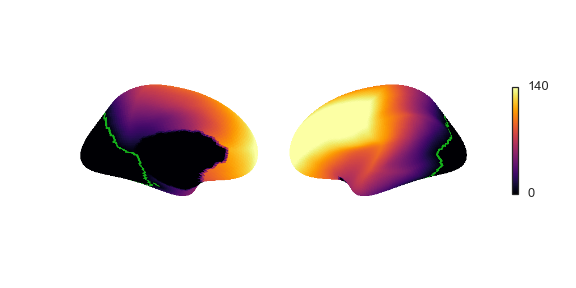

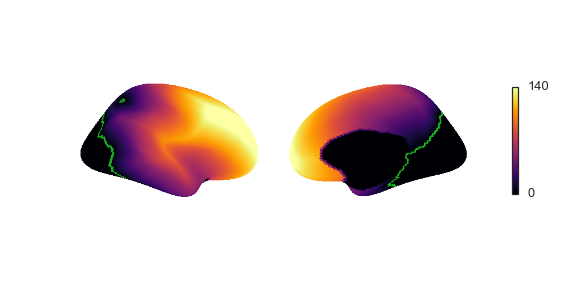

0.070947962966


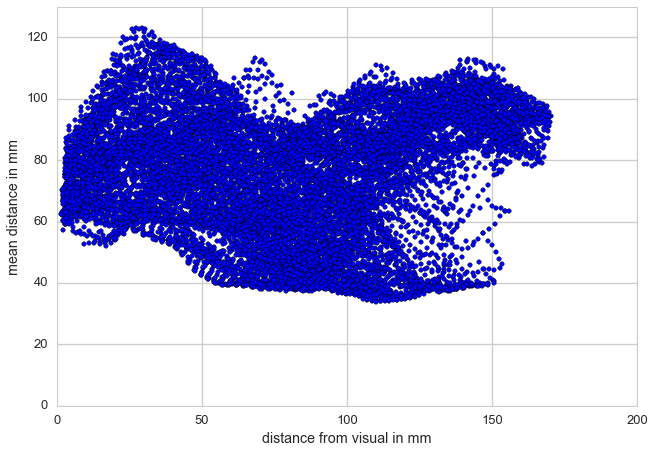

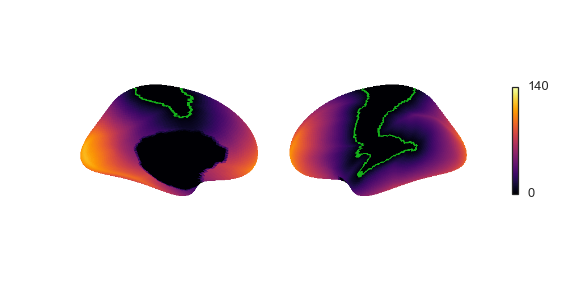

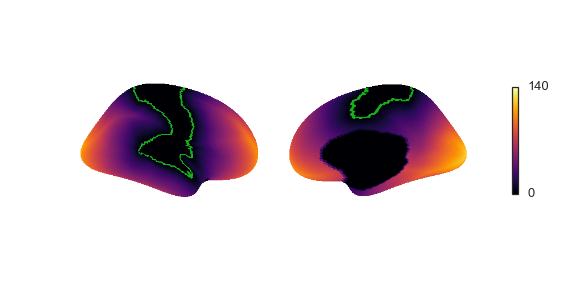

-0.166776101303


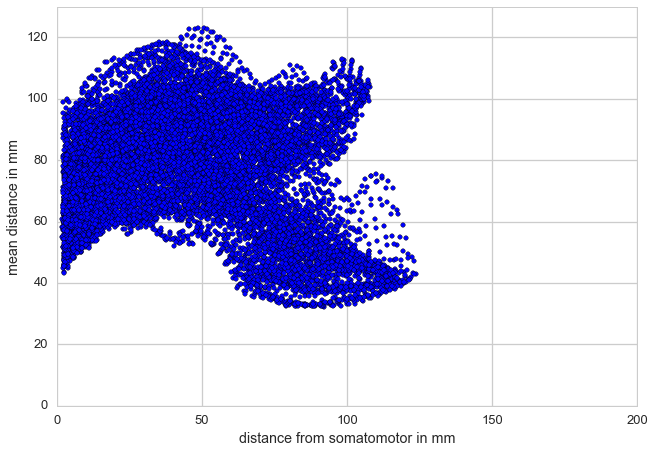

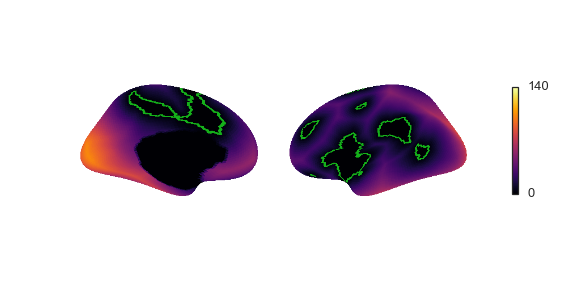

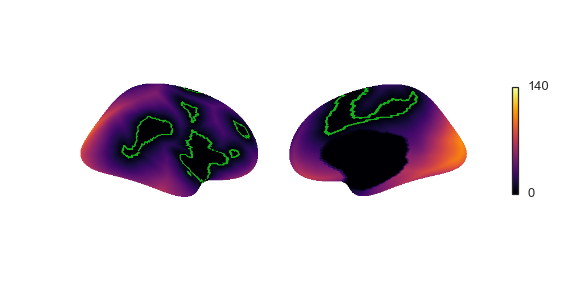

-0.246586440434


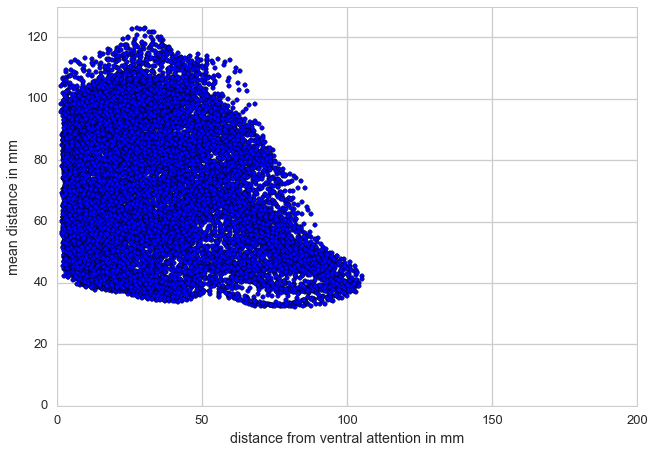

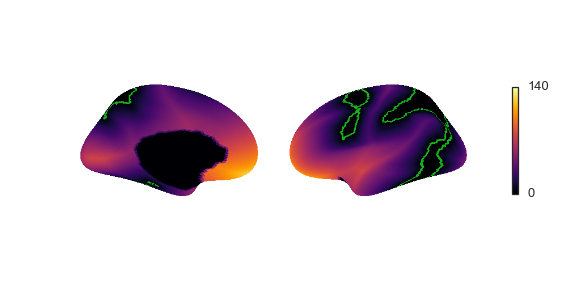

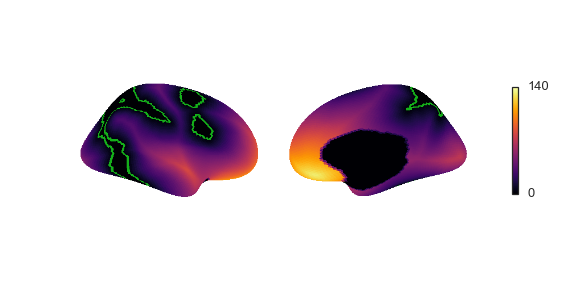

0.145332614837


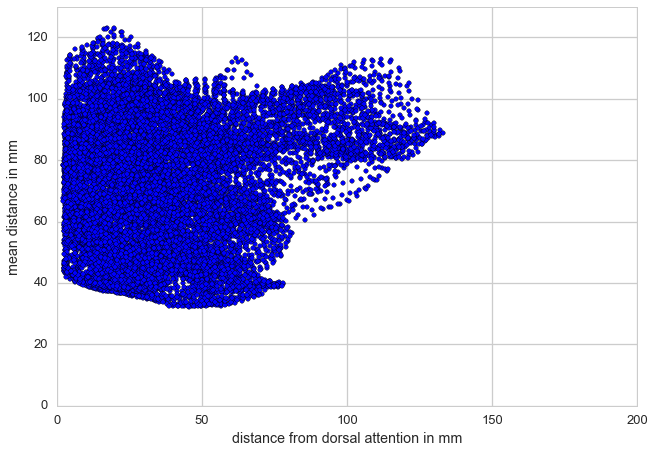

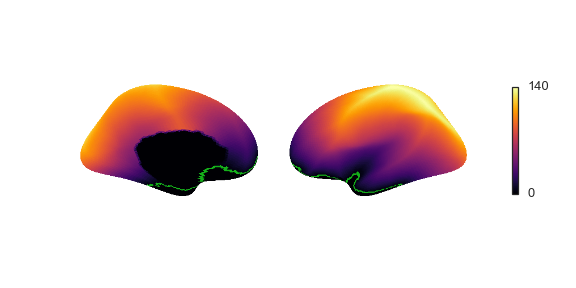

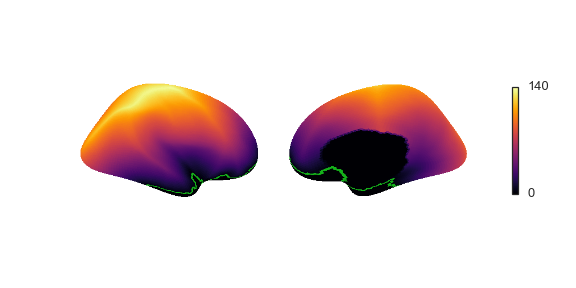

-0.245268327317


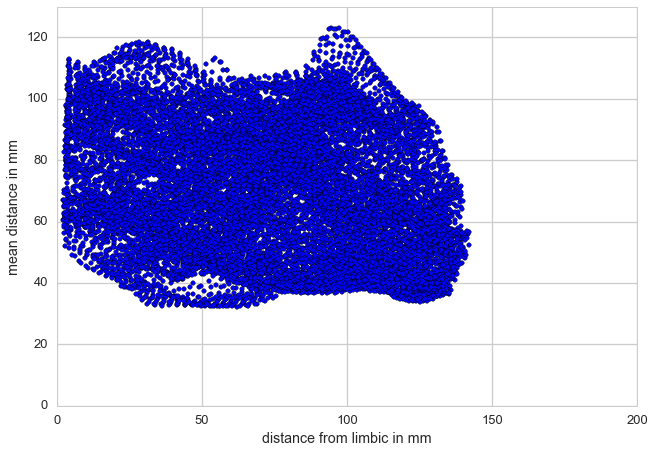

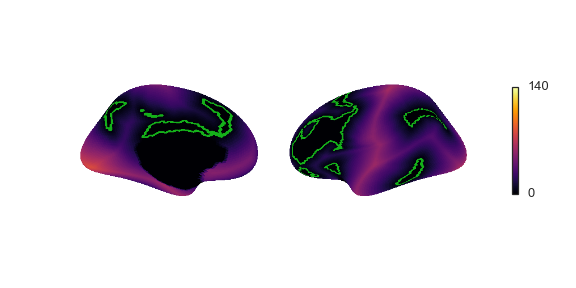

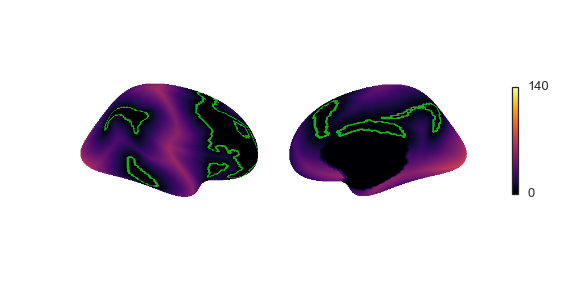

-0.613104654167


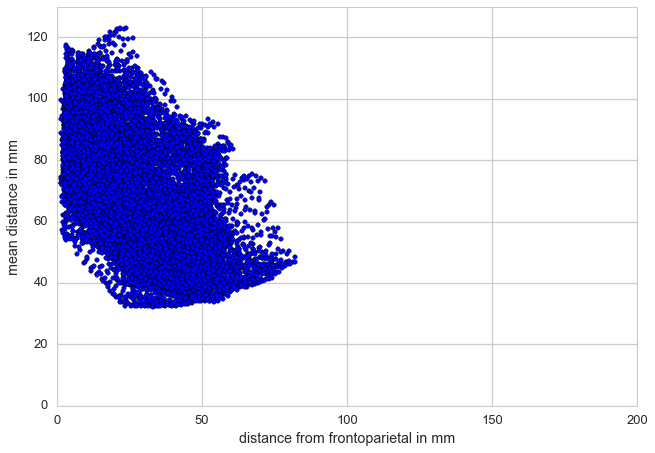

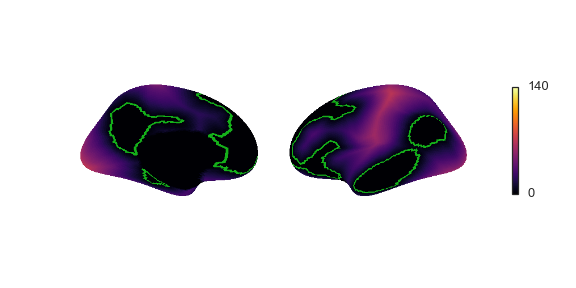

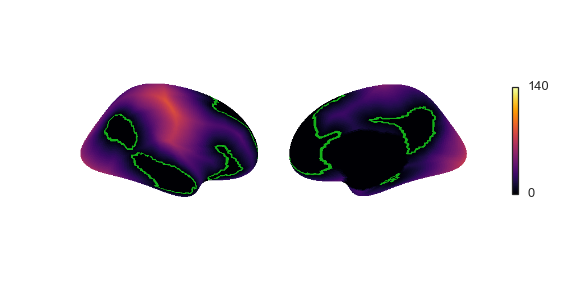

-0.641771358551


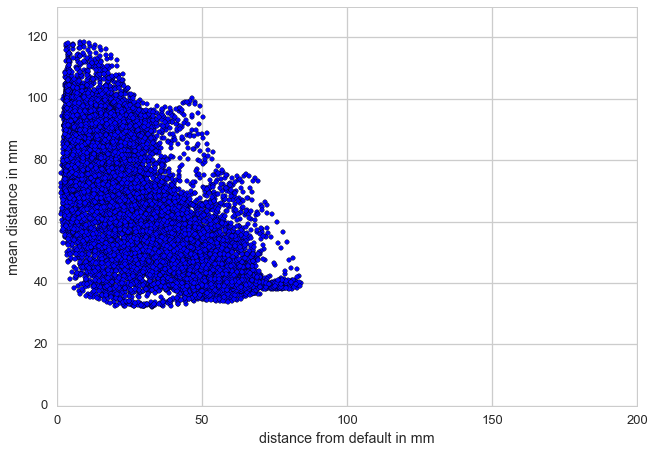

In [302]:
networks = ['visual', 'somatomotor', 'ventral attention', 
            'dorsal attention', 'limbic', 'frontoparietal', 'default']
corr_r = []

for netw in networks:

    dist_to_netw_both = []
    meanDist_netw_both = []


    for hemi in ['lh', 'rh']:

        # component labels ('annot format') and group distance
        if hemi == 'lh':
            comp_labels = [np.where(comp_labels_lh == comp)[0] for comp in range(1,n_comp+1)]
            gr_dist = gr_dist_lh
        if hemi == 'rh':
            comp_labels = [np.where(comp_labels_rh == comp)[0] for comp in range(1,n_comp+1)]
            gr_dist = gr_dist_rh


        # mean distance map
        meanDist = df_mm[['mean distance (geodesic) - group mean']][df_mm['hemisphere'] == hemi].as_matrix().squeeze()


        # distance to network
        netw_labels = map(int, 
                      df_mm['node'][(df_mm['hemisphere'] == hemi) 
                                    & (df_mm['networks of Yeo & Krienen 2011 (7 networks solution)']==netw)].tolist())

        dist_to_netw = np.array([min(gr_dist[node][netw_labels]) for node in range((10242))])

        cort = np.sort(nib.freesurfer.io.read_label('%s/fsaverage5/label/%s.cortex.label' % (fsDir, hemi)))
        rest_netw_labels = np.array(list(set(cort).difference(set(netw_labels))))

        # combine distance maps from hemis
        dist_to_netw_both.extend(list(dist_to_netw[rest_netw_labels]))
        meanDist_netw_both.extend(list(meanDist[rest_netw_labels]))

        # plots
        sns.set_style('white')
        create_fig(data=dist_to_netw, labels=[netw_labels], label_col='green', hemi=hemi, surf='inflated', 
                   cmap='inferno', sulc=False,cbar=True, dmin=0, dmax=140) #dmax=np.percentile(trmap, 95)


    # combine hemispheres
    sns.set_style('whitegrid')
    r = np.corrcoef(dist_to_netw_both, meanDist_netw_both)[0, 1]
    print r
    corr_r.append(r)
    f, ax = plt.subplots()
    plt.scatter(dist_to_netw_both, meanDist_netw_both)
    ax.set_ylabel('mean distance in mm')
    ax.set_xlabel('distance from %s in mm' % netw)
    plt.axis((0,200, 0, 130))
    plt.show()





In [301]:
np.corrcoef(dist_to_netw_both, meanDist_netw_both)

array([[ 1.        ,  0.07094796],
       [ 0.07094796,  1.        ]])

In [295]:
networks

['visual',
 'somatomotor',
 'ventral attention',
 'dorsal attention',
 'limbic',
 'frontoparietal',
 'default']

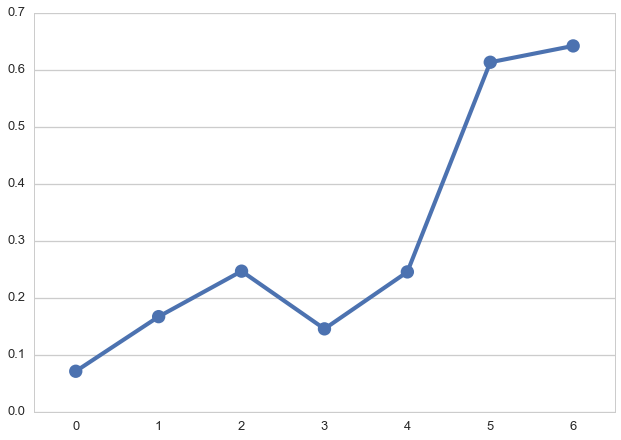

In [298]:
corr_r_abs = [abs(r) for r in corr_r]
sns.pointplot(range(len(corr_r)), corr_r_abs)

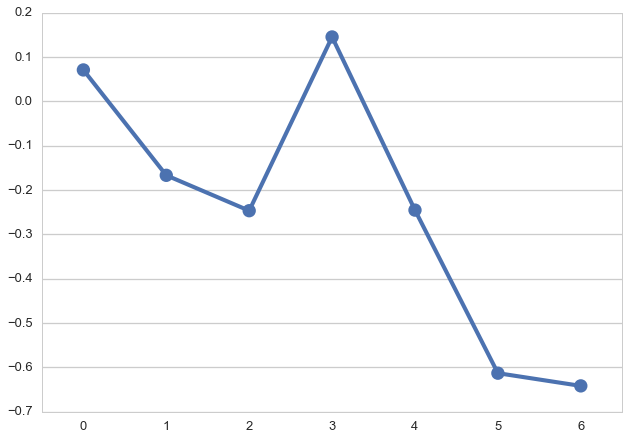

In [297]:
sns.pointplot(range(len(corr_r)), corr_r)

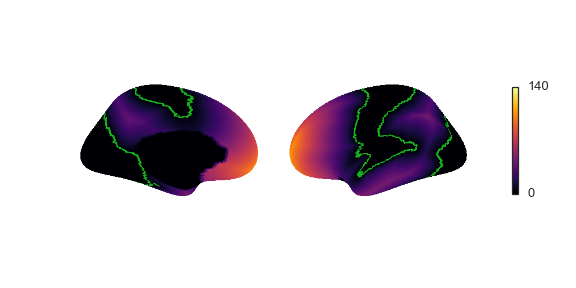

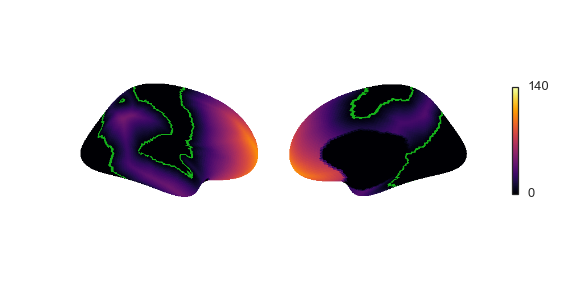

0.483172896596


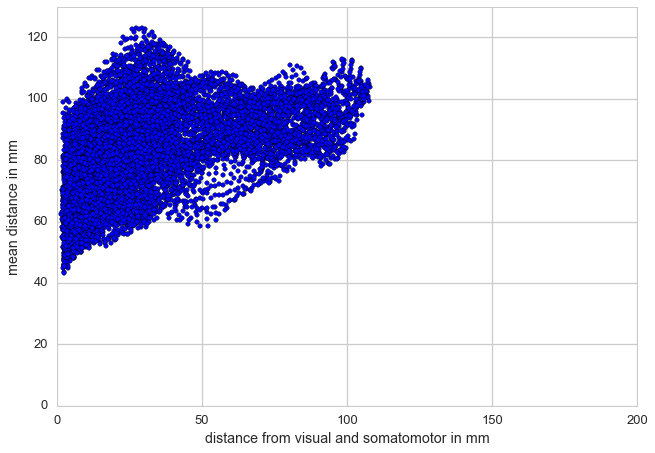

In [304]:

dist_to_netw_both = []
meanDist_netw_both = []


for hemi in ['lh', 'rh']:

    # component labels ('annot format') and group distance
    if hemi == 'lh':
        comp_labels = [np.where(comp_labels_lh == comp)[0] for comp in range(1,n_comp+1)]
        gr_dist = gr_dist_lh
    if hemi == 'rh':
        comp_labels = [np.where(comp_labels_rh == comp)[0] for comp in range(1,n_comp+1)]
        gr_dist = gr_dist_rh


    # mean distance map
    meanDist = df_mm[['mean distance (geodesic) - group mean']][df_mm['hemisphere'] == hemi].as_matrix().squeeze()


    # distance to network
    netw_labels_vis = map(int, 
                  df_mm['node'][(df_mm['hemisphere'] == hemi) 
                                & (df_mm['networks of Yeo & Krienen 2011 (7 networks solution)']=='visual')].tolist())

    netw_labels_somatomotor = map(int, 
                  df_mm['node'][(df_mm['hemisphere'] == hemi) 
                                & (df_mm['networks of Yeo & Krienen 2011 (7 networks solution)']=='somatomotor')].tolist())
    
    netw_labels = netw_labels_vis + netw_labels_somatomotor
    
    
    dist_to_netw = np.array([min(gr_dist[node][netw_labels]) for node in range((10242))])

    cort = np.sort(nib.freesurfer.io.read_label('%s/fsaverage5/label/%s.cortex.label' % (fsDir, hemi)))
    rest_netw_labels = np.array(list(set(cort).difference(set(netw_labels))))

    # combine distance maps from hemis
    dist_to_netw_both.extend(list(dist_to_netw[rest_netw_labels]))
    meanDist_netw_both.extend(list(meanDist[rest_netw_labels]))

    # plots
    sns.set_style('white')
    create_fig(data=dist_to_netw, labels=[netw_labels], label_col='green', hemi=hemi, surf='inflated', 
               cmap='inferno', sulc=False,cbar=True, dmin=0, dmax=140) #dmax=np.percentile(trmap, 95)


# combine hemispheres
sns.set_style('whitegrid')
r = np.corrcoef(dist_to_netw_both, meanDist_netw_both)[0, 1]
print r
corr_r.append(r)
f, ax = plt.subplots()
plt.scatter(dist_to_netw_both, meanDist_netw_both)
ax.set_ylabel('mean distance in mm')
ax.set_xlabel('distance from visual and somatomotor in mm')
plt.axis((0,200, 0, 130))
plt.show()




lh


rh


hemispheres combined, used smallest component to define primary regions


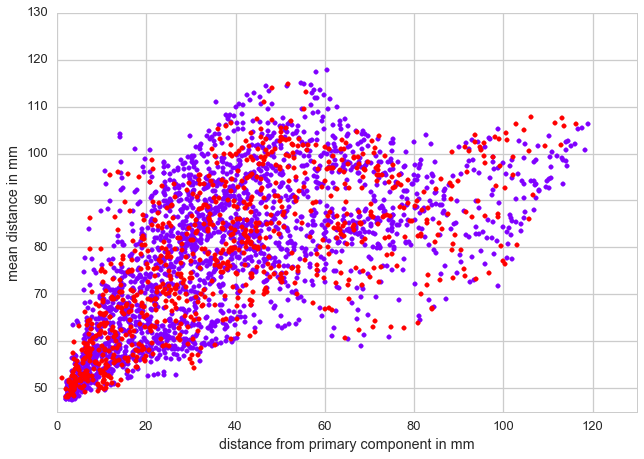



hemispheres combined, used ćortical areas to define primary regions


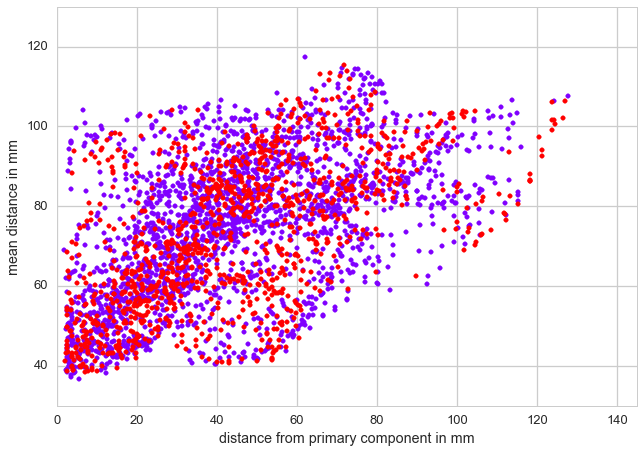

In [255]:
dist_to_primary_comp_both = []
meanDist_comp_both =[]
networks_comp_both = []

dist_to_primary_areas_both = []
meanDist_areas_both =[]
networks_areas_both = []


for hemi in ['lh', 'rh']:
    print '\n\n%s' % hemi
    
    # component labels ('annot format') and group distance
    if hemi == 'lh':
        comp_labels = [np.where(comp_labels_lh == comp)[0] for comp in range(1,n_comp+1)]
        gr_dist = gr_dist_lh
    if hemi == 'rh':
        comp_labels = [np.where(comp_labels_rh == comp)[0] for comp in range(1,n_comp+1)]
        gr_dist = gr_dist_rh
    
    
    # mean distance map
    meanDist = df_mm[['mean distance (geodesic) - group mean']][df_mm['hemisphere'] == hemi].as_matrix().squeeze()
     
    # distance to primary component
    comp_order = np.argsort([meanDist[comp_labels[comp]].mean() for comp in range(n_comp)])  
    primary_comp_labels = comp_labels[comp_order[0]]
    rest_comp_labels = np.sort(np.concatenate((comp_labels[comp_order[1]],comp_labels[comp_order[2]])))
    dist_to_primary_comp = np.array([min(gr_dist[node][primary_comp_labels]) for node in range((10242))])
    
    # distance to primary areas
    primary_area_labels = []
    primary_cortices = ['G_postcentral','G_precentral','S_calcarine','S_central','S_temporal_transverse']
    for area in primary_cortices:
        temp = map(int, list(set(df['node'][(df['region in Destrieux Atlas']==area)&(df['hemisphere']==hemi)])))
        primary_area_labels.extend(np.sort(np.array(temp)))
    primary_area_labels = np.sort(list(set(primary_area_labels)))
    dist_to_primary_areas = np.array([min(gr_dist[node][primary_area_labels]) for node in range((10242))])
    cort = np.sort(nib.freesurfer.io.read_label('%s/fsaverage5/label/%s.cortex.label' % (fsDir, hemi)))
    rest_area_labels = np.array(list(set(cort).difference(set(primary_area_labels))))
    
    # networks
    network_labels = np.array(df_mm['networks of Yeo & Krienen 2011 (7 networks solution)'][df_mm['hemisphere'] == hemi])
    
    
    
    # combine distance maps from hemis
    dist_to_primary_comp_both.extend(list(dist_to_primary_comp[rest_comp_labels]))
    meanDist_comp_both.extend(list(meanDist[rest_comp_labels]))
    networks_comp_both.extend(list(network_labels[rest_comp_labels]))
    
    dist_to_primary_areas_both.extend(list(dist_to_primary_areas[rest_area_labels]))
    meanDist_areas_both.extend(list(meanDist[rest_area_labels]))
    networks_areas_both.extend(list(network_labels[rest_area_labels]))
    

    
# combine hemispheres
networks = ['default','visual']
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, len(networks)))

print '\n\nhemispheres combined, used smallest component to define primary regions'
sns.set_style('whitegrid')
f, ax = plt.subplots()
for n, netw in enumerate(networks):
    netw_label = np.where(np.array(networks_comp_both)[rest_area_labels]==netw)[0]
    plt.scatter(np.array(dist_to_primary_comp_both)[netw_label], np.array(meanDist_comp_both)[netw_label],
               color=colors[n])
ax.set_ylabel('mean distance in mm')
ax.set_xlabel('distance from primary component in mm')
plt.axis((0,130, 45, 130))
plt.show()



print '\n\nhemispheres combined, used ćortical areas to define primary regions'
sns.set_style('whitegrid')
f, ax = plt.subplots()
for n, netw in enumerate(networks):
    netw_label = np.where(np.array(networks_areas_both)[rest_area_labels]==netw)[0]
    plt.scatter(np.array(dist_to_primary_areas_both)[netw_label], np.array(meanDist_areas_both)[netw_label],
               color=colors[n])
ax.set_ylabel('mean distance in mm')
ax.set_xlabel('distance from primary component in mm')
plt.axis((0,145, 30, 130))
plt.show()

In [253]:
set(network_labels)

{'default',
 'dorsal attention',
 'frontoparietal',
 'limbic',
 'medial wall',
 'somatomotor',
 'ventral attention',
 'visual'}

In [ ]:
networks = ['visual', 'default']

G_postcentral
G_precentral
S_calcarine
S_central
S_temporal_transverse


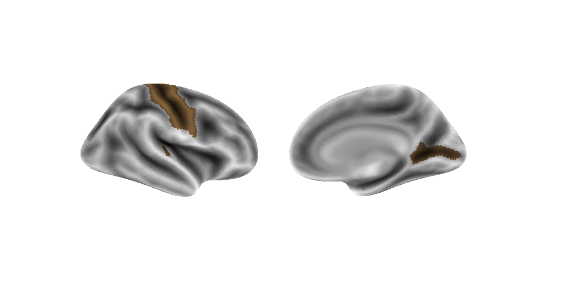

In [171]:
region_labels = []
primary_cortices = ['G_postcentral','G_precentral','S_calcarine','S_central','S_temporal_transverse']

for region in primary_cortices:
    temp = map(int, list(set(df['node'][(df['region in Destrieux Atlas']==region)&(df['hemisphere']==hemi)])))
    region_labels.extend(np.sort(np.array(temp)))
    
create_fig(labels=[region_labels], hemi=hemi, surf='inflated', cbar=True, cpal='cubehelix')

G_postcentral
G_precentral
S_calcarine
S_central
S_temporal_transverse


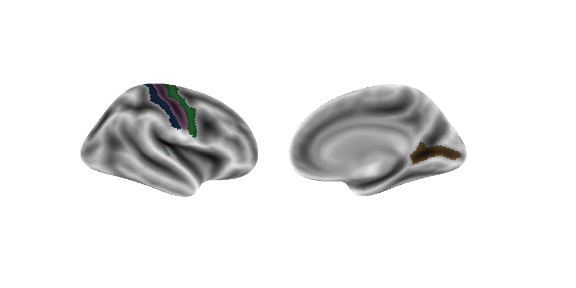

In [169]:
region_labels = []
primary_cortices = ['G_postcentral','G_precentral','S_calcarine','S_central','S_temporal_transverse']

for region in primary_cortices:
    print region
    temp = map(int, list(set(df['node'][(df['region in Destrieux Atlas']==region)&(df['hemisphere']==hemi)])))
    region_labels.append(np.sort(np.array(temp)))
    
create_fig(labels=region_labels, hemi=hemi, surf='inflated', cbar=True, cpal='cubehelix')

G_postcentral


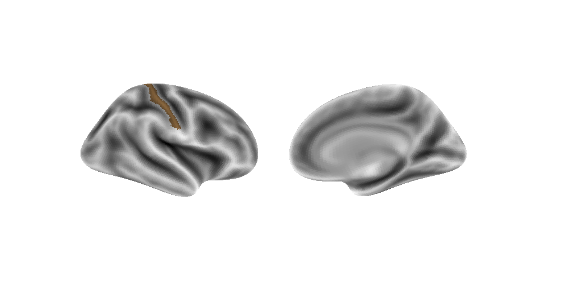

G_precentral


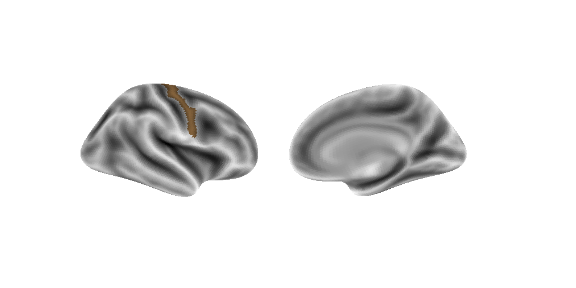

S_calcarine


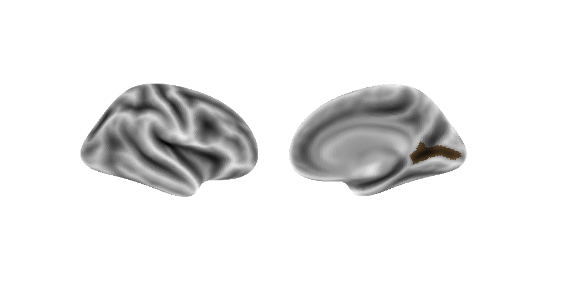

S_central


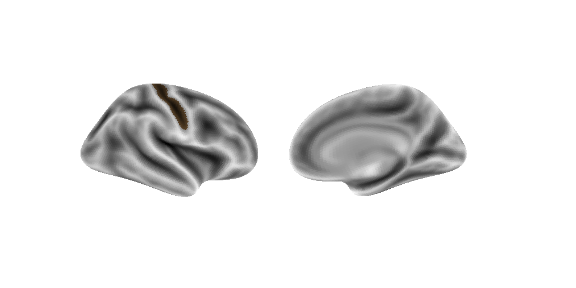

S_postcentral


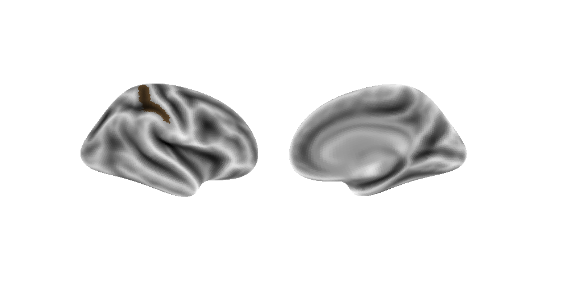

S_precentral-inf-part


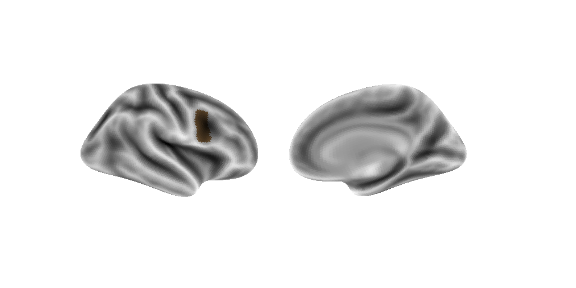

S_precentral-sup-part


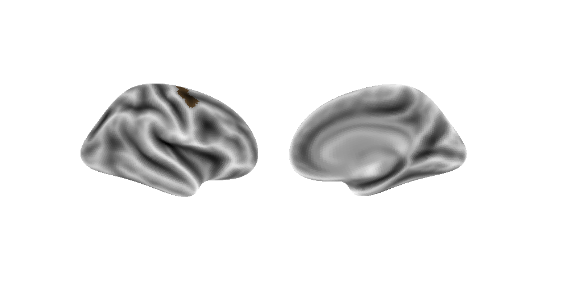

S_temporal_transverse


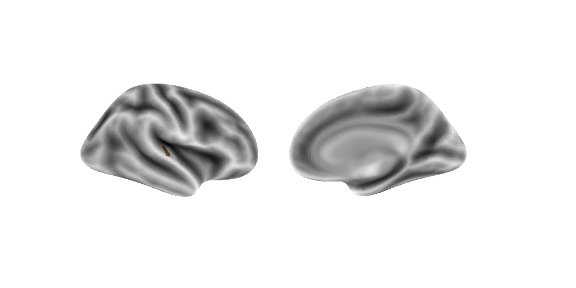

In [168]:
#primary_cortices = ['G_postcentral', 'G_precentral','S_calcarine','S_central',]

for n, region in enumerate(primary_cortices):
    print region
    create_fig(labels=[region_labels[n]], hemi=hemi, surf='inflated', cbar=True, cpal='cubehelix')

In [26]:
hemi = 'lh'

cort = np.sort(nib.freesurfer.io.read_label('%s/fsaverage5/label/%s.cortex.label' % (fsDir, hemi)))

surf_f = '%s/fsaverage5/surf/%s.orig' % (fsDir, hemi)
faces = nib.freesurfer.io.read_geometry(surf_f)[1]

border_nodes = []

for node in cort:
    neighbors = np.unique(faces[np.where(np.in1d(faces.ravel(), [node]).reshape(faces.shape))[0]])
    if len(set(comp_labels_lh[neighbors])) == 2:
        border_nodes.append(node)
    else:
        pass
        
border_nodes = np.array(border_nodes)
# for each node on cortex, get neigbors
# get neigbors label from network_map
# if length of set(labels) is 1 --> no border node
# if length > 1 --> border node
# save index and 2 bordering networks

In [29]:
border_nodes


array([    7,    12,    17, ..., 10230, 10231, 10232])

In [32]:
gr_dist_lh.shape

(10242, 10242)

In [37]:
dists_from_comp_borders = np.zeros((10242))

for node in cort:
    # find distance to all border nodes, pick closest
    dists_from_comp_borders[node] = min(gr_dist_lh[node][border_nodes])

In [40]:
dists_from_comp_borders[cort]

array([  4.96297935,  10.12884078,   2.84602675, ...,  13.68567169,
        16.35756468,  16.75004247])

In [41]:
trmap = create_trmap(data, hemi)

In [ ]:
sns.lmplot("x", "y", data=df, hue='dataset', fit_reg=False)

In [42]:
sns.lmplot(dists_from_comp_borders[cort], trmap[cort])

TypeError: lmplot() takes at least 3 arguments (2 given)

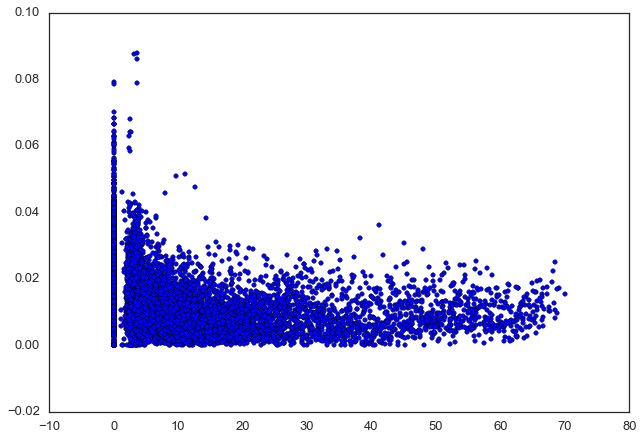

In [43]:
plt.scatter(dists_from_comp_borders[cort], trmap[cort])

In [51]:
df_test = pd.DataFrame(data={'distance from component borders': dists_from_comp_borders[cort], 
                        'transition speed': trmap[cort]})

/scr/ilz1/cbspython_surf/surfenv/local/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


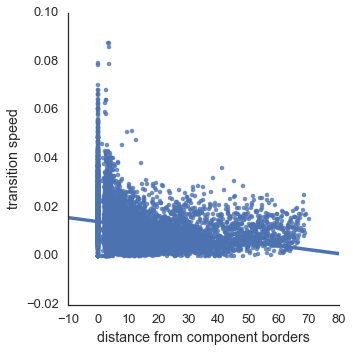

In [52]:
sns.lmplot(x="distance from component borders", y="transition speed", data=df_test)

In [48]:
df_test

{'distance from component borders': array([  4.96297935,  10.12884078,   2.84602675, ...,  13.68567169,
         16.35756468,  16.75004247]),
 'transition speed': array([ 0.00910163,  0.00418261,  0.00812699, ...,  0.01025467,
         0.00681717,  0.00103575])}


lh


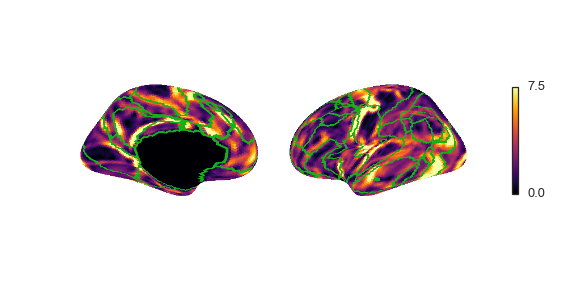


rh


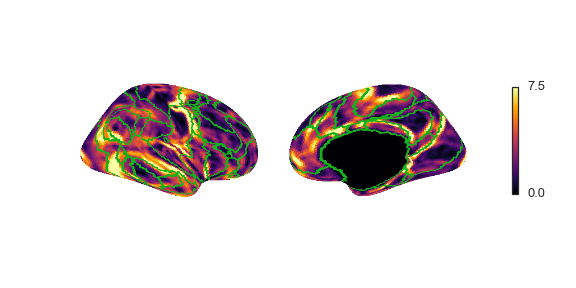

In [6]:
sns.set_style('white')


for hemi in ['lh', 'rh']:
    print '\n%s' % hemi
    data = np.array(df_mm[['mean distance (geodesic) - group mean']][(df_mm['threshold'] == '95')
                                                       & (df_mm['hemisphere'] == hemi)])

    netw_labels = tuple([df_mm['node'][(df_mm['networks of Yeo & Krienen 2011 (17 networks solution)'] == netw) 
                             & (df_mm['hemisphere'] == hemi)
                             & (df_mm['threshold'] == '95')]
                         for netw in yeo17[2]])

    trmap = create_trmap(data, hemi)
    create_fig(data=trmap, labels=netw_labels, label_col='green', hemi=hemi, surf='inflated', 
               cmap='inferno', dmin=0, dmax=7.5, sulc=False,cbar=True) #dmax=np.percentile(trmap, 95)


lh


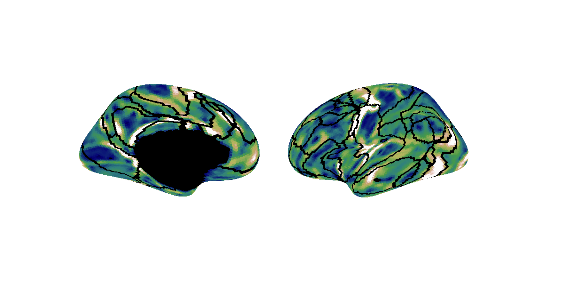


rh


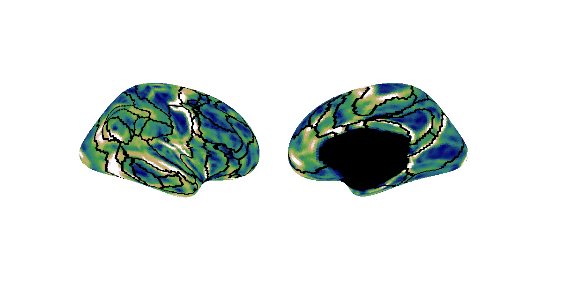

In [8]:
sns.set_style('white')
sns.set_context('poster')

for hemi in ['lh', 'rh']:
    print '\n%s' % hemi
    data = np.array(df_mm[['mean distance (geodesic) - group mean']][(df_mm['threshold'] == '95')
                                                       & (df_mm['hemisphere'] == hemi)])

    netw_labels = tuple([df_mm['node'][(df_mm['networks of Yeo & Krienen 2011 (17 networks solution)'] == netw) 
                             & (df_mm['hemisphere'] == hemi)
                             & (df_mm['threshold'] == '95')]
                         for netw in yeo17[2]])

    trmap = create_trmap(data, hemi)
    create_fig(data=trmap, labels=netw_labels, hemi=hemi, surf='inflated', 
               cmap='gist_earth', dmax=np.percentile(trmap, 95), sulc=False,cbar=False)


lh


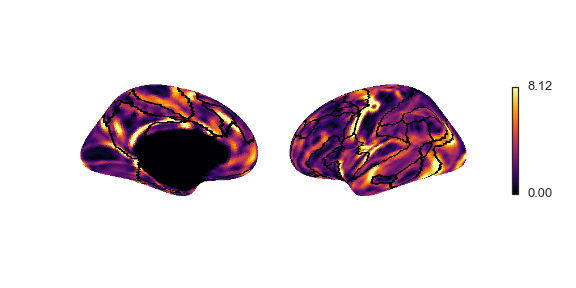


rh


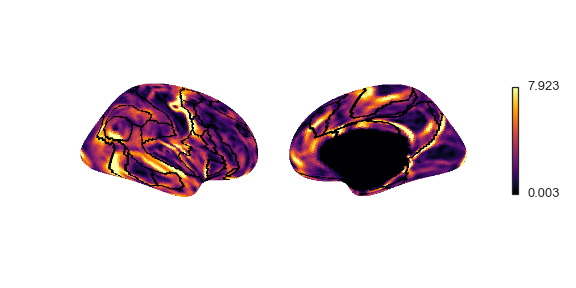

In [8]:
sns.set_style('white')


for hemi in ['lh', 'rh']:
    print '\n%s' % hemi
    data = np.array(df_mm[['mean distance (geodesic) - group mean']][(df_mm['threshold'] == '95')
                                                       & (df_mm['hemisphere'] == hemi)])

    netw_labels = tuple([df_mm['node'][(df_mm['networks of sample (7 networks solution)'] == netw) 
                             & (df_mm['hemisphere'] == hemi)
                             & (df_mm['threshold'] == '95')]
                         for netw in yeo7_names])

    trmap = create_trmap(data, hemi)
    create_fig(data=trmap, labels=netw_labels, hemi=hemi, surf='inflated', 
               cmap='inferno', dmax=np.percentile(trmap, 96), sulc=False,cbar=True)

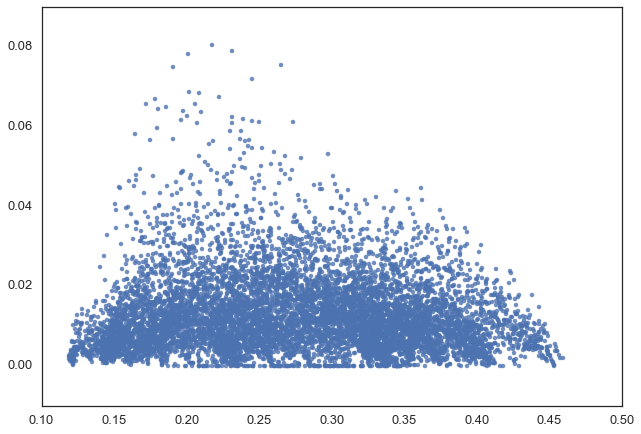

In [41]:
cort = np.sort(nib.freesurfer.io.read_label('%s/fsaverage5/label/%s.cortex.label' % (fsDir, hemi)))
sns.regplot(data[cort], trmap[cort], fit_reg=False)